In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy as sp
import scipy.stats
import seaborn as sns
from matplotlib import cm
import networkx as nx
import pandas as pd
import itertools
from matplotlib import animation
import os
# Using matplotlib notebook allows you to interact with the resulting 3-D figure
%matplotlib inline

In [2]:
import sys
sys.path.append(r'src')
import curvgrad as cg
import trngln
from importlib import reload
reload(cg)
reload(trngln)

<module 'trngln' from 'src/trngln.py'>

In [3]:
# two methods for animation - see:
# http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-as-interactive-javascript-widgets/
# 1 - directly inline via %matplotlib notebook - advantage: real-time, disadvantage: no manual control
# 2 - encode as video, embedded into notebook (base64) and display via notebook player or JS widget
#     downside - not real time, need to generate complete video before it can be displayed
# 2a - HTML(anim.to_html5_video())  [notebook player, bare bones] [uses html5 <video> tag]
# 2b - HTML(anim.to_jshtml())  [JS widget, extra controls]
# these latter can be made default representation via next line, which can also be 'html5'
mp.rcParams['animation.html'] = 'jshtml'
# 3 - save as an animated GIF and display using 
# rot_animation.save('rotation.gif', dpi=80, writer='imagemagick')
# ![RotatingImage](rotation.gif "Quadratic Form")
# see also https://stackoverflow.com/questions/35532498/animation-in-ipython-notebook/46878531#46878531

In [4]:
refc = pd.read_csv('Data/mark_us_curv.csv', index_col = 0)
refc.columns = refc.columns.astype('float')

### Create the 3D Mesh and its Triangulation

First create a 2D x-y mesh

In [5]:
cellcoords = np.array(list(itertools.product(refc.index, refc.columns)), dtype='float')
# we assume that ncols = nrows in the input dataframe
gridsize = len(refc.columns)
x = np.reshape(cellcoords[:,0], (gridsize, gridsize))
y = np.reshape(cellcoords[:,1], (gridsize, gridsize))
z = np.zeros((gridsize, gridsize))
curvatures = np.reshape([refc.loc[x, y] for x, y in itertools.product(refc.index, refc.columns)], 
                        (gridsize, gridsize))

In [6]:
# x and y are the corresponding indices of a 2D mesh
# x, y = np.mgrid[-edge:edge:.05, -edge:edge:.05]
# create the structure needed for evaluating pdfs
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
gridsize = x.shape[0]

Now create the triangulation of the 3D mesh

In [7]:
Tr = trngln.trngln(gridsize)
triangles = Tr.triangles()

In [8]:
G = Tr.regularization_graph()
L = nx.laplacian_matrix(G)
L3 = L @ L @ L

In [9]:
xf = x.flatten()
yf = y.flatten()
zf = z.flatten()

In [10]:
def get_triangle_vertices(triangles, xf, yf, zf):
    # this is the actual mesh we will plot
    return np.array([np.array([[xf[T[0]], yf[T[0]], zf[T[0]]],
                                    [xf[T[1]], yf[T[1]], zf[T[1]]],
                                    [xf[T[2]], yf[T[2]], zf[T[2]]]]) for T in triangles])
def get_vertices(xf, yf, zf):
    # list of coordinates of each triangle
    return np.array(list(zip(xf, yf, zf)))

triangle_vertices = get_triangle_vertices(triangles, xf, yf, zf)
vertices = get_vertices(xf, yf, zf)

### Visualization of Meshes

In [11]:
def viz(triangle_vertices, facecolors):

    # plot the triangle mesh
    coll = Poly3DCollection(triangle_vertices, facecolors=facecolors, linewidth=0.1,
                        edgecolors='gray')

    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    ax.add_collection(coll)
    ax.view_init(elev=0, azim=135)

    plt.axis('off')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-1, 1)
    ax.elev = 50
    return ax

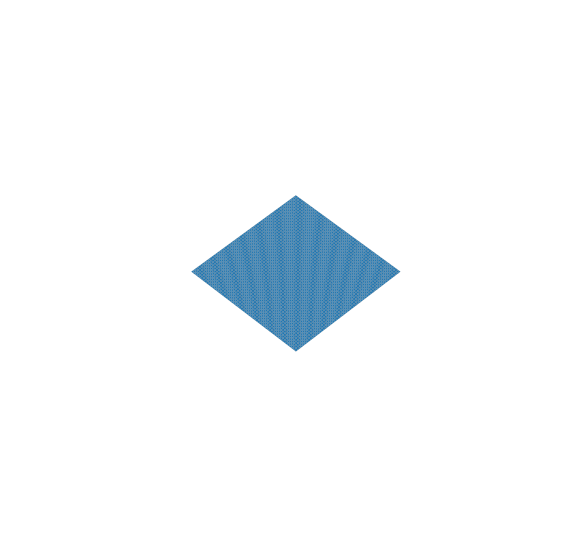

In [12]:
viz(triangle_vertices, None)

#### Coloring a mesh according to curvature

__Basic idea of how to color the mesh:__

1. For each vertex, get all adjacent triangles
    * For each triangle, compute its angle at that vertex
    * Then sum all angles to compute the local curvature at that vertex
3. For each triangle, compute average curvature of its vertices
4. Color the triangle according to the average curvature of its vertices

__Geometry:__

Given a triangle with vertices $p_0, p_1, p_2$.   Assume you want to compute the angle at vertex $p_0$.

Let $v = p_1 - p_0,$ $u = p_2 - p_0$.  Then $\theta = \cos^{-1}\frac{u^T v}{\Vert u\Vert \Vert v\Vert}$

#### Compute the angle of vertex $b$ in triangle $T$

In [13]:
def angle_of_b_in_t(b, T, vertices):
    '''
    for a vertex b which is an index into vertices
    and a triangle T (which is a triple)
    return the angle formed by the two triangles sides at vertex b
    '''
    others = [t for t in T if t != b]
    u = np.array(vertices[others[0]] - vertices[b])
    v = np.array(vertices[others[1]] - vertices[b])
    return np.arccos((u.T @ v) / (np.linalg.norm(u) * np.linalg.norm(v)))

#### Compute the curvature at vertex $b$.

The curvature at a vertex $= 2 \pi - \sum$ angles around vertex

In [14]:
def vertex_curvature(b, t_of_v, vertices):
    # find the angles of the edges incident at each vertex b
    # t_of_v[b] is the set of triangles incident to vertex b
    angles = [angle_of_b_in_t(b, t, vertices) for t in t_of_v[b]]
    if len(angles) == 6:
        # this is an interior vertex
        return 2 * np.pi - np.sum(angles)
    #elif len(angles) == 3:
        #return np.pi - np.sum(angles)
    #elif len(angles) == 2:
        #return (np.pi / 2) - np.sum(angles)
    #elif len(angles) == 1:
        #return (np.pi / 2) - np.sum(angles)
    else:
        # this vertex does not have the standard number of neighbors (6)
        # which happens at the edge of the mesh
        # so just ignore it - will be filtered out of the visualization
        return np.nan 
    
def get_curvature(vertices, t_of_v):
    return np.array([vertex_curvature(v, t_of_v, vertices) for v in range(len(vertices))])

Apply the above functions to compute the curvature at each vertex

In [15]:
t_of_v = Tr.triangles_of_vertex()

#### Visualize

Given the above histogram, the small number of points with very large curvature will distort the scale and hide the variation of curvature around zero.   So we artificially clamp all values above a threshold, and rescale the values close to zero so they can be seen.

In [16]:
def rmap(x, oldmin, newmin, oldmax, newmax, newzero):
    '''
    linear rescaling for visualization purposes
    rescale from range [oldmin, 0] to [newmin, newzero]
    and from [0, oldmax] to [newzero, newmax]
    '''
    if x > 0:
        return (x/oldmax)*(newmax-newzero)+newzero
    elif x < 0:
        return (x/oldmin)*(newmin-newzero)+newzero
    else:
        return newzero
        
def viz_curvature(vertices, t_of_v, triangles, cmap = cm.seismic, maxscale = 0.1):
    
    # compute the curvature at each vertex
    cv = get_curvature(vertices, t_of_v)
    
    # Compute the average curvature for each triangle
    pcv = np.array([np.nanmean(cv[triangles[t]]) for t in range(len(triangles))])

    # for visualization, concentrate on intermediate curvature values
    # only visualize cuvatures in range [-maxscale, maxscale]
    # all other values are set to maxscale or -maxscale

    # first, set all values above maxscale to maxscale 
    pcv[pcv > maxscale] = maxscale
    pcv[pcv < -maxscale] = -maxscale
    
    # remap values and compute colors of each triangle
    facecolors = cmap([rmap(p, -maxscale, 0, maxscale, 1, 0.5) for p in pcv])

    viz(triangle_vertices, facecolors);

## Warping a surface to match a curvature

### Build a test case

Get a curvature value for each point

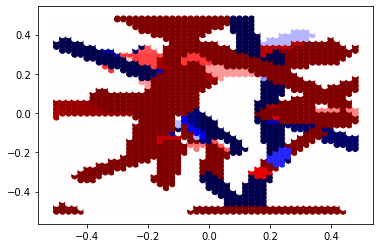

In [17]:
cmap = cm.seismic
maxscale = 0.1
plt.scatter(xf, yf, color = [cmap(rmap(p, -maxscale, 0, maxscale, 1, 0.5)) for p in curvatures.flatten()])

### Loss Function

Let the intended curvature at grid point $i$ be $\kappa(i)$ and the current curvature be $c(i)$.   Then to match the observed curvature, the objective function is:

$$ \mathcal{L} = \sum_i (\kappa(i) - c(i))^2. $$

Each point has three coordinates, ie, $a = (x_a, y_a, z_a)$.  In order to use gradient descent to minimize this loss function we need to compute
$$ \frac{\partial \mathcal{L}}{\partial z} $$
where $z = [z_i]^T$.  Written out, the above is $[\frac{\partial \mathcal{L}}{\partial z_i}]^T$.

### Gradient

The gradient we seek is:
    $$ \frac{\partial \mathcal{L}}{\partial z} = \sum_i 2(\kappa(i) - c(i))\left(-\frac{\partial c(i)}{\partial z}\right) $$
    
(which could be 
    $$ \frac{\partial \mathcal{L}}{\partial z} = \sum_i 2(\kappa(i) - c(i))\left(-\frac{\partial c(i)}{\partial z}\right) + \lambda \frac{\partial f}{\partial z}$$
   if we want to smooth the curvature using one of the above penalizations $f(z)$.)

### Functions for computing gradient

In [18]:
# test case
kappa = curvatures.flatten()

In [19]:
zf = 0.001 * curvatures.flatten()
# zf = 0.001 * np.random.random(576)
vertices = get_vertices(xf, yf, zf)
c = get_curvature(vertices, t_of_v)

In [20]:
grad = cg.L_grad(len(vertices), kappa, c, t_of_v, vertices)

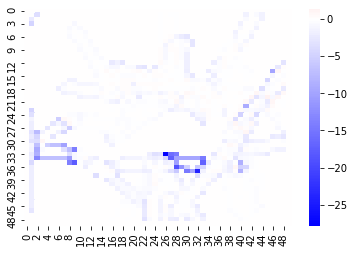

In [21]:
sns.heatmap(np.reshape(grad, (gridsize, gridsize)), cmap = cm.bwr, center = 0)

(2500,)

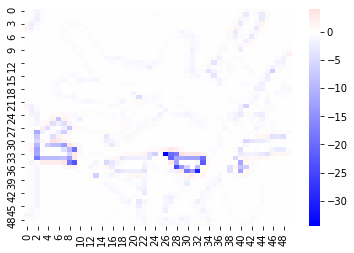

In [22]:
grad = cg.L_grad_penalized(1000, L @ zf, len(vertices), kappa, c, t_of_v, vertices)
sns.heatmap(np.reshape(grad, (gridsize, gridsize)), cmap = cm.bwr, center = 0)
np.ravel(grad).shape

In [23]:
def objfn(kappa, c):
    diff = kappa-c
    diff = diff * diff
    return np.nansum(diff)

def complete_objfn(kappa, c, smooth_pen, penval):
    ob = objfn(kappa, c)
    return ob + smooth_pen * penval

In [24]:
objfn(kappa, c)

145.4669441549581

In [25]:
def single_step(smooth_pen, rate, vertices, kappa, cv_in, t_of_v, xf, yf, zf):
    grad = cg.L_grad_penalized(smooth_pen, L3 @ zf, len(vertices), kappa, cv_in, t_of_v, vertices)
    # grad, penalty = L_grad_penalized_with_convexity(100, L, zf, 10, L3 @ zf, len(vertices), kappa, cv_in, t_of_v, vertices)
    # grad = L_grad_penalized_biased(10, 10, L3 @ zf, len(vertices), kappa, cv_in, t_of_v, vertices)
    new_zf = zf - rate * grad
    new_vertices = get_vertices(xf, yf, new_zf)
    new_cv = get_curvature(new_vertices, t_of_v)
    return new_zf, new_cv, new_vertices, grad

def single_step_with_momentum(prev_step, momentum, smooth_pen, rate, vertices, kappa, cv_in, t_of_v, xf, yf, zf):
    grad = cg.L_grad_penalized(smooth_pen, L3 @ zf, len(vertices), kappa, cv_in, t_of_v, vertices)
    prev_step = ((1-momentum) * grad) + (momentum * prev_step)
    new_zf = zf - rate * prev_step
    new_vertices = get_vertices(xf, yf, new_zf)
    new_cv = get_curvature(new_vertices, t_of_v)
    return new_zf, new_cv, new_vertices, prev_step

In [26]:
def generate_surface(smooth_pen, rate, momentum, kappa, xf, yf, t_of_v, niter = 1000, verbose = False):
    # initialize
    zf = kappa.copy()
    zf[np.isnan(zf)] = 0
    zf[zf<0] = 0
    vertices = get_vertices(xf, yf, zf)
    cv = get_curvature(vertices, t_of_v)
    of = objfn(kappa, cv)
    cof = complete_objfn(kappa, cv, smooth_pen, zf.T @ L3 @ zf)
    old_of = of
    old_cof = cof
    errvals = []
    c_errvals = []
    #
    # initial rate setting
    if verbose:
        print('starting rate setting: rate: {} obj fn: {} complete obj fn: {}'.format(rate, of, cof))   
    new_zf, new_cv, new_vertices, prev_step = single_step(smooth_pen, rate, vertices, kappa, cv, t_of_v, xf, yf, zf)
    while (complete_objfn(kappa, new_cv, smooth_pen, new_zf.T @ L3 @ new_zf) > old_cof):
        rate = rate / 1.1
        new_zf, new_cv, new_vertices, prev_step = single_step(smooth_pen, rate, vertices, kappa, cv, t_of_v, xf, yf, zf)
        if verbose:
            print('setup: -- lowering rate to {}'.format(rate))
    old_cof = complete_objfn(kappa, new_cv, smooth_pen, new_zf.T @ L3 @ new_zf)
    old_of = objfn(kappa, new_cv)
    zf = new_zf
    cv = new_cv
    vertices = new_vertices
    if verbose:
        print('finished rate setting: rate: {} obj fn: {} complete obj fn: {}'.format(rate, old_of, old_cof))
    #
    # main loop
    for i in range(niter):
        # new_zf, new_cv, new_vertices, prev_step = single_step(
        #    smooth_pen, rate, vertices, kappa, cv, t_of_v, xf, yf, zf)
        new_zf, new_cv, new_vertices, prev_step = single_step_with_momentum(prev_step, momentum,
            smooth_pen, rate, vertices, kappa, cv, t_of_v, xf, yf, zf)
        of = objfn(kappa, new_cv)
        cof = complete_objfn(kappa, new_cv, smooth_pen, new_zf.T @ L3 @ new_zf)
        # print('step: {} rate: {} obj fn: {} complete obj fn:{}'.format(i, rate, of, cof))
        if (cof > old_cof):
            rate = rate / 1.1
            if verbose:
                print('step: {} -- lowering rate to {}'.format(i, rate))
        elif (cof == old_cof):
            # rate has gone so low that no progress at all is being made
            rate = rate * 1.1
            if verbose:
                print('step: {} -- raising rate to {}'.format(i, rate))
        else:
            errvals.append(of)
            c_errvals.append(cof)
            old_of = of
            old_cof = cof
            zf = new_zf
            cv = new_cv
            vertices = new_vertices
            if (0 == i % 100):
                if verbose:
                    print('step: {}, obj fn: {}'.format(i, of))
                #fig, axs = plt.subplots(1, 3, figsize=(15,5))
                #sns.heatmap(np.reshape(new_zf, (gridsize, gridsize)), cmap = cm.bwr, center = 0, ax = axs[0])
                #sns.heatmap(np.reshape(new_cv, (gridsize, gridsize)), cmap = cm.bwr, vmin = -1, vmax = 1, center = 0, ax = axs[1])
                #sns.heatmap(np.reshape(kappa, (gridsize, gridsize)), cmap = cm.bwr, vmin = -1, vmax = 1, center = 0, ax = axs[2])
    if verbose:
        print('Done: final error: {}'.format(of))
    return zf, cv, errvals, c_errvals

In [27]:
def document_run(runname, zf, cv, errvals, c_errvals, kappa, gridsize):
    # error plots
    plt.figure()
    plt.plot(errvals, '-')
    plt.yscale('log')
    plt.suptitle('Loss for Curvature Only')
    plt.title(runname)
    plt.savefig('{}/curvature-error.png'.format(runname))
    #
    plt.figure()
    plt.plot(c_errvals, '-')
    plt.yscale('log')
    plt.suptitle('Complete Objective Function')
    plt.title(runname)
    plt.savefig('{}/objective-function.png'.format(runname))
    #
    plt.figure()
    sns.heatmap(np.reshape(kappa, (gridsize, gridsize)), cmap = cm.bwr, vmin = -1, vmax = 1, center = 0)
    plt.suptitle('Target Curvature Map')
    plt.title(runname)
    plt.savefig('{}/target-curvature-map.png'.format(runname))
    #
    plt.figure()
    sns.heatmap(np.reshape(cv, (gridsize, gridsize)), cmap = cm.bwr, vmin = -1, vmax = 1, center = 0)
    plt.suptitle('Output Curvature Map')
    plt.title(runname)
    plt.savefig('{}/output-curvature-map.png'.format(runname))

In [28]:
def generate_plots(runname, gridsize, xf, yf, zf, cv, locnamefile, refc):
    # first visualize colored with curvature
    fig = plt.figure(figsize = (12, 12))
    ax = fig.add_subplot(111, projection='3d')
    x = np.reshape(xf, (gridsize, gridsize))
    y = np.reshape(yf, (gridsize, gridsize))
    z = np.reshape(zf, (gridsize, gridsize))
    cvcol = cv.copy()
    cvcol[np.isnan(cvcol)] = 0
    maxscale = .5
    cvcol = cmap([rmap(p, -  maxscale, 0, maxscale, 1, 0.5) for p in cvcol])
    cvcol = np.reshape(cvcol, (gridsize, gridsize, 4))
    ax.plot_surface(x, y, z, facecolors = cvcol)
    plt.savefig('{}/surface-with-curvature.png'.format(runname))
    #
    # now visualize with solid color and location names
    fig = plt.figure(figsize = (12, 12))
    ax = fig.add_subplot(111, projection='3d')
    ls = mp.colors.LightSource(azdeg = 270, altdeg = 30)
    ax.view_init(azim = 315, elev = 75)
    plt.axis('off')
    ax.plot_surface(x, y, z, rcount = gridsize, ccount = gridsize, color='skyblue', lightsource = ls) #, facecolors = cvcol, lightsource = ls)
    labels = pd.read_csv(locnamefile)
    x_axis_vals = list(refc.columns.values)
    y_axis_vals = list(refc.index.values)
    for i in labels.iterrows():
        lbl = i[1][0]
        xpt = i[1][1]
        ypt = i[1][2]
        xndx = x_axis_vals.index(i[1][1])
        yndx = y_axis_vals.index(i[1][2])
        zpt = z[yndx, xndx]
        ax.text(ypt, xpt, zpt, lbl, color='red')
    plt.savefig('{}/surface-with-labels.png'.format(runname))
    #
    # generate animated gif
    def rotate(angle):
        ax.view_init(azim = angle, elev = 75)
        
    rot_animation = animation.FuncAnimation(fig, 
                                        rotate, 
                                        frames=np.arange(0,360,5), 
                                        interval=100, 
                                        repeat=False)
    plt.close()
    fname = '{}/animation.gif'.format(runname)
    rot_animation.save(fname, dpi=80, writer='imagemagick')

In [29]:
rate = 0.0001
smooth_pen = 1
momentum = 0.9
niter = 1000

starting rate setting: rate: 0.0001 obj fn: 2053.772845995889 complete obj fn: 7974.667041321158
finished rate setting: rate: 0.0001 obj fn: 2784.039260670277 complete obj fn: 7228.231388473303
step: 0 -- lowering rate to 9.09090909090909e-05
step: 1 -- lowering rate to 8.264462809917355e-05
step: 5 -- lowering rate to 7.513148009015777e-05
step: 7 -- lowering rate to 6.830134553650706e-05
step: 100, obj fn: 142.91349724482686
step: 200, obj fn: 124.49181669464559
step: 300, obj fn: 123.87445424631376
step: 400, obj fn: 123.11793940661326
step: 441 -- lowering rate to 6.20921323059155e-05
step: 454 -- lowering rate to 5.644739300537773e-05
step: 458 -- lowering rate to 5.131581182307066e-05
step: 460 -- lowering rate to 4.665073802097332e-05
step: 461 -- lowering rate to 4.240976183724847e-05
step: 463 -- lowering rate to 3.8554328942953155e-05
step: 465 -- lowering rate to 3.504938994813923e-05
step: 500, obj fn: 120.80904196106059
step: 600, obj fn: 121.15001102371897
step: 700, obj 

step: 972 -- lowering rate to 6.799702492444859e-11
step: 973 -- lowering rate to 6.181547720404416e-11
step: 974 -- lowering rate to 5.619588836731287e-11
step: 975 -- lowering rate to 5.1087171243011696e-11
step: 976 -- lowering rate to 4.6442882948192444e-11
step: 977 -- lowering rate to 4.222080268017495e-11
step: 978 -- lowering rate to 3.838254789106813e-11
step: 979 -- lowering rate to 3.489322535551648e-11
step: 980 -- lowering rate to 3.172111395956043e-11
step: 981 -- lowering rate to 2.8837376326873116e-11
step: 982 -- lowering rate to 2.621579666079374e-11
step: 983 -- lowering rate to 2.3832542418903398e-11
step: 984 -- lowering rate to 2.1665947653548543e-11
step: 985 -- lowering rate to 1.9696316048680493e-11
step: 986 -- lowering rate to 1.790574186243681e-11
step: 987 -- lowering rate to 1.6277947147669826e-11
step: 988 -- lowering rate to 1.479813377060893e-11
step: 989 -- lowering rate to 1.3452848882371755e-11
step: 990 -- lowering rate to 1.2229862620337958e-11
ste

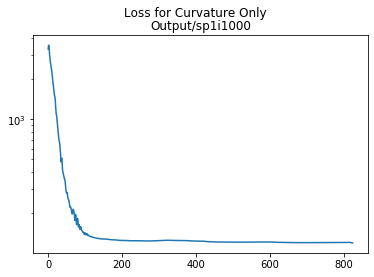

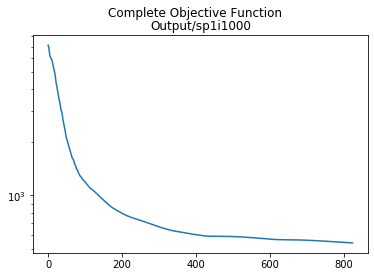

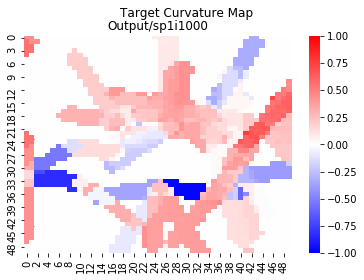

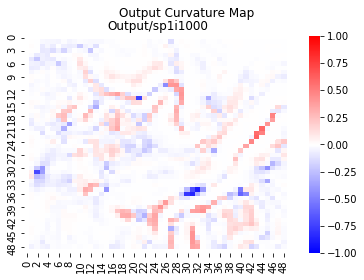

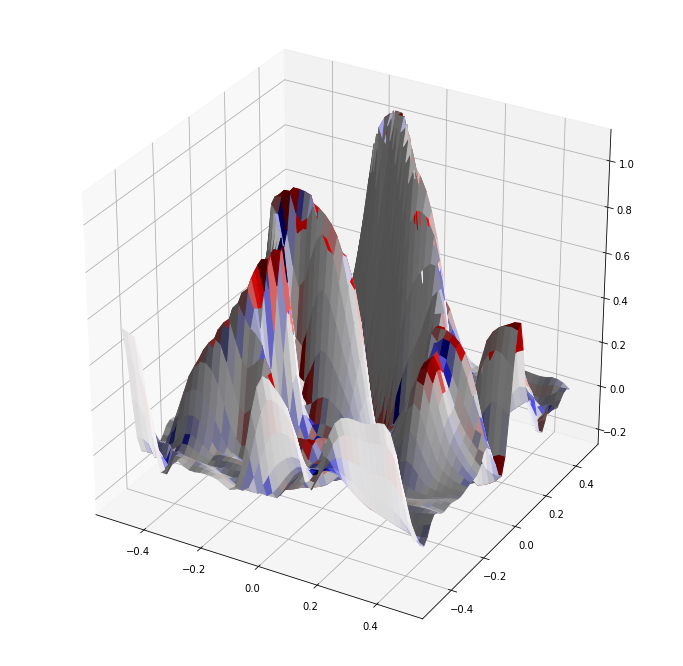

In [30]:
zf, cv, errvals, c_errvals = generate_surface(smooth_pen, rate, momentum, kappa, xf, yf, 
                                              t_of_v, niter = niter, verbose = True)
runname = 'Output/sp{:d}i{:d}'.format(smooth_pen, niter)
try:
    os.mkdir(runname)
except FileExistsError:
    pass
document_run(runname, zf, cv, errvals, c_errvals, kappa, gridsize)
generate_plots(runname, gridsize, xf, yf, zf, cv, 'Data/map_points.csv', refc)

starting rate setting: rate: 0.0001 obj fn: 2053.772845995889 complete obj fn: 61262.71479924858
finished rate setting: rate: 0.0001 obj fn: 2515.1018086413783 complete obj fn: 16867.41059761401
step: 0 -- lowering rate to 9.09090909090909e-05
step: 1 -- lowering rate to 8.264462809917355e-05
step: 2 -- lowering rate to 7.513148009015777e-05
step: 3 -- lowering rate to 6.830134553650706e-05
step: 4 -- lowering rate to 6.20921323059155e-05
step: 5 -- lowering rate to 5.644739300537773e-05
step: 6 -- lowering rate to 5.131581182307066e-05
step: 8 -- lowering rate to 4.665073802097332e-05
step: 9 -- lowering rate to 4.240976183724847e-05
step: 12 -- lowering rate to 3.8554328942953155e-05
step: 100, obj fn: 145.91427392500395
step: 183 -- lowering rate to 3.504938994813923e-05
step: 186 -- lowering rate to 3.1863081771035665e-05
step: 187 -- lowering rate to 2.8966437973668783e-05
step: 188 -- lowering rate to 2.633312543060798e-05
step: 189 -- lowering rate to 2.3939204936916344e-05
step

step: 329 -- lowering rate to 4.222080268017495e-11
step: 330 -- lowering rate to 3.838254789106813e-11
step: 331 -- lowering rate to 3.489322535551648e-11
step: 332 -- lowering rate to 3.172111395956043e-11
step: 333 -- lowering rate to 2.8837376326873116e-11
step: 334 -- lowering rate to 2.621579666079374e-11
step: 335 -- lowering rate to 2.3832542418903398e-11
step: 336 -- lowering rate to 2.1665947653548543e-11
step: 337 -- lowering rate to 1.9696316048680493e-11
step: 338 -- lowering rate to 1.790574186243681e-11
step: 339 -- lowering rate to 1.6277947147669826e-11
step: 340 -- lowering rate to 1.479813377060893e-11
step: 341 -- lowering rate to 1.3452848882371755e-11
step: 342 -- lowering rate to 1.2229862620337958e-11
step: 343 -- lowering rate to 1.1118056927579962e-11
step: 344 -- lowering rate to 1.0107324479618146e-11
step: 345 -- lowering rate to 9.18847679965286e-12
step: 346 -- lowering rate to 8.353160726957144e-12
step: 347 -- lowering rate to 7.593782479051949e-12
step

step: 488 -- raising rate to 1.090219609419071e-16
step: 489 -- lowering rate to 9.91108735835519e-17
step: 490 -- raising rate to 1.090219609419071e-16
step: 491 -- lowering rate to 9.91108735835519e-17
step: 492 -- raising rate to 1.090219609419071e-16
step: 493 -- lowering rate to 9.91108735835519e-17
step: 494 -- raising rate to 1.090219609419071e-16
step: 495 -- lowering rate to 9.91108735835519e-17
step: 496 -- raising rate to 1.090219609419071e-16
step: 497 -- lowering rate to 9.91108735835519e-17
step: 498 -- raising rate to 1.090219609419071e-16
step: 499 -- lowering rate to 9.91108735835519e-17
step: 500 -- raising rate to 1.090219609419071e-16
step: 501 -- lowering rate to 9.91108735835519e-17
step: 502 -- raising rate to 1.090219609419071e-16
step: 503 -- lowering rate to 9.91108735835519e-17
step: 504 -- raising rate to 1.090219609419071e-16
step: 505 -- lowering rate to 9.91108735835519e-17
step: 506 -- raising rate to 1.090219609419071e-16
step: 507 -- lowering rate to 9

step: 649 -- lowering rate to 9.91108735835519e-17
step: 650 -- raising rate to 1.090219609419071e-16
step: 651 -- lowering rate to 9.91108735835519e-17
step: 652 -- raising rate to 1.090219609419071e-16
step: 653 -- lowering rate to 9.91108735835519e-17
step: 654 -- raising rate to 1.090219609419071e-16
step: 655 -- lowering rate to 9.91108735835519e-17
step: 656 -- raising rate to 1.090219609419071e-16
step: 657 -- lowering rate to 9.91108735835519e-17
step: 658 -- raising rate to 1.090219609419071e-16
step: 659 -- lowering rate to 9.91108735835519e-17
step: 660 -- raising rate to 1.090219609419071e-16
step: 661 -- lowering rate to 9.91108735835519e-17
step: 662 -- raising rate to 1.090219609419071e-16
step: 663 -- lowering rate to 9.91108735835519e-17
step: 664 -- raising rate to 1.090219609419071e-16
step: 665 -- lowering rate to 9.91108735835519e-17
step: 666 -- raising rate to 1.090219609419071e-16
step: 667 -- lowering rate to 9.91108735835519e-17
step: 668 -- raising rate to 1.

step: 810 -- raising rate to 1.090219609419071e-16
step: 811 -- lowering rate to 9.91108735835519e-17
step: 812 -- raising rate to 1.090219609419071e-16
step: 813 -- lowering rate to 9.91108735835519e-17
step: 814 -- raising rate to 1.090219609419071e-16
step: 815 -- lowering rate to 9.91108735835519e-17
step: 816 -- raising rate to 1.090219609419071e-16
step: 817 -- lowering rate to 9.91108735835519e-17
step: 818 -- raising rate to 1.090219609419071e-16
step: 819 -- lowering rate to 9.91108735835519e-17
step: 820 -- raising rate to 1.090219609419071e-16
step: 821 -- lowering rate to 9.91108735835519e-17
step: 822 -- raising rate to 1.090219609419071e-16
step: 823 -- lowering rate to 9.91108735835519e-17
step: 824 -- raising rate to 1.090219609419071e-16
step: 825 -- lowering rate to 9.91108735835519e-17
step: 826 -- raising rate to 1.090219609419071e-16
step: 827 -- lowering rate to 9.91108735835519e-17
step: 828 -- raising rate to 1.090219609419071e-16
step: 829 -- lowering rate to 9

step: 971 -- lowering rate to 9.91108735835519e-17
step: 972 -- raising rate to 1.090219609419071e-16
step: 973 -- lowering rate to 9.91108735835519e-17
step: 974 -- raising rate to 1.090219609419071e-16
step: 975 -- lowering rate to 9.91108735835519e-17
step: 976 -- raising rate to 1.090219609419071e-16
step: 977 -- lowering rate to 9.91108735835519e-17
step: 978 -- raising rate to 1.090219609419071e-16
step: 979 -- lowering rate to 9.91108735835519e-17
step: 980 -- raising rate to 1.090219609419071e-16
step: 981 -- lowering rate to 9.91108735835519e-17
step: 982 -- raising rate to 1.090219609419071e-16
step: 983 -- lowering rate to 9.91108735835519e-17
step: 984 -- raising rate to 1.090219609419071e-16
step: 985 -- lowering rate to 9.91108735835519e-17
step: 986 -- raising rate to 1.090219609419071e-16
step: 987 -- lowering rate to 9.91108735835519e-17
step: 988 -- raising rate to 1.090219609419071e-16
step: 989 -- lowering rate to 9.91108735835519e-17
step: 990 -- raising rate to 1.

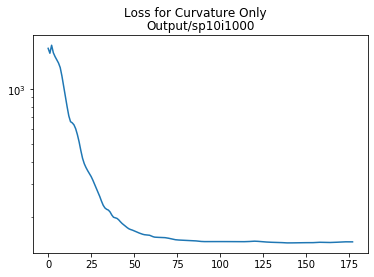

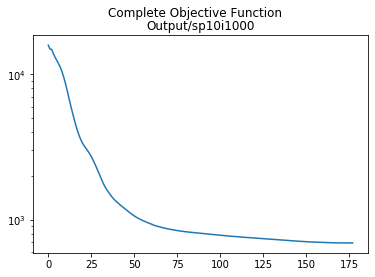

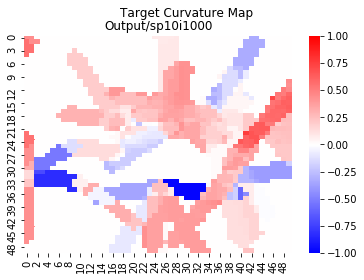

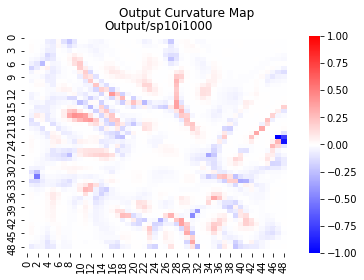

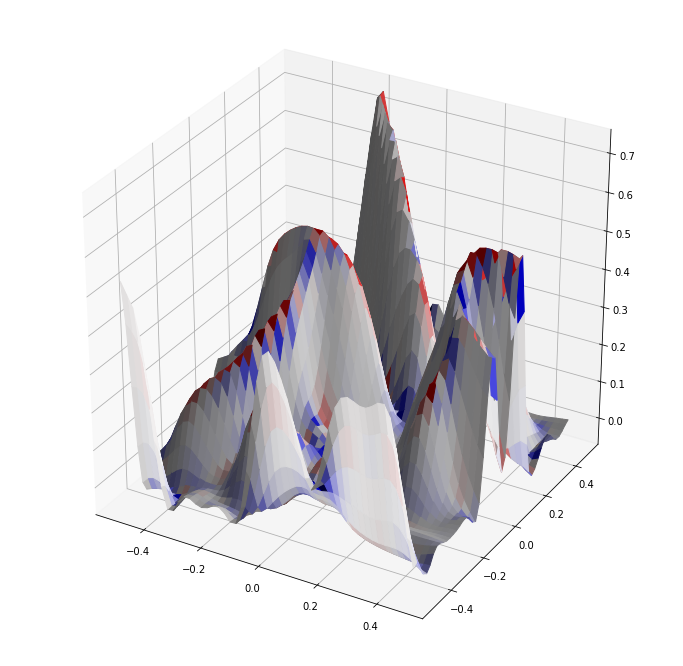

In [31]:
smooth_pen = 10
niter = 1000
momentum = 0.9
zf, cv, errvals, c_errvals = generate_surface(smooth_pen, rate, momentum, kappa, xf, yf, 
                                              t_of_v, niter = niter, verbose = True)
runname = 'Output/sp{:d}i{:d}'.format(smooth_pen, niter)
try:
    os.mkdir(runname)
except FileExistsError:
    pass
document_run(runname, zf, cv, errvals, c_errvals, kappa, gridsize)
generate_plots(runname, gridsize, xf, yf, zf, cv, 'Data/map_points.csv', refc)

starting rate setting: rate: 0.0001 obj fn: 2053.772845995889 complete obj fn: 594143.1923785227
setup: -- lowering rate to 9.09090909090909e-05
setup: -- lowering rate to 8.264462809917355e-05
setup: -- lowering rate to 7.513148009015777e-05
setup: -- lowering rate to 6.830134553650706e-05
setup: -- lowering rate to 6.20921323059155e-05
setup: -- lowering rate to 5.644739300537773e-05
setup: -- lowering rate to 5.131581182307066e-05
setup: -- lowering rate to 4.665073802097332e-05
setup: -- lowering rate to 4.240976183724847e-05
setup: -- lowering rate to 3.8554328942953155e-05
setup: -- lowering rate to 3.504938994813923e-05
setup: -- lowering rate to 3.1863081771035665e-05
setup: -- lowering rate to 2.8966437973668783e-05
setup: -- lowering rate to 2.633312543060798e-05
setup: -- lowering rate to 2.3939204936916344e-05
setup: -- lowering rate to 2.1762913579014857e-05
setup: -- lowering rate to 1.9784466890013503e-05
setup: -- lowering rate to 1.7985878990921365e-05
finished rate se

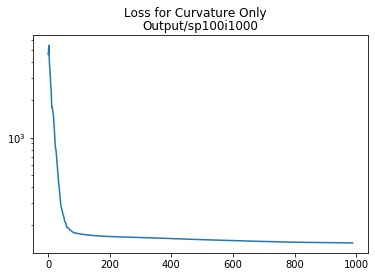

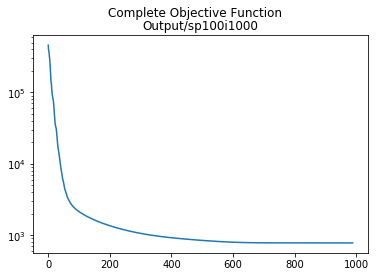

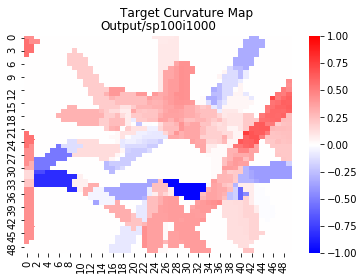

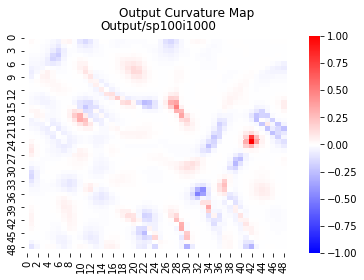

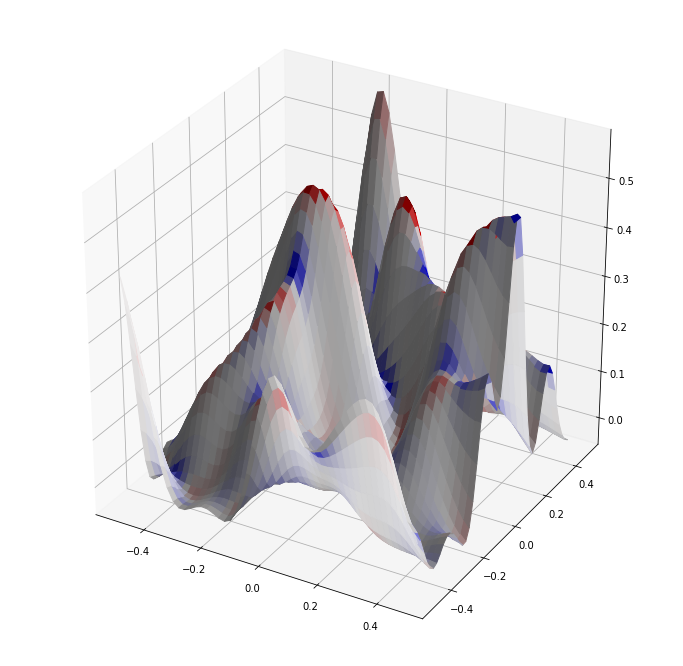

In [32]:
smooth_pen = 100
niter = 1000
momentum = 0.9
zf, cv, errvals, c_errvals = generate_surface(smooth_pen, rate, momentum, kappa, xf, yf, 
                                              t_of_v, niter = niter, verbose = True)
runname = 'Output/sp{:d}i{:d}'.format(smooth_pen, niter)
try:
    os.mkdir(runname)
except FileExistsError:
    pass
document_run(runname, zf, cv, errvals, c_errvals, kappa, gridsize)
generate_plots(runname, gridsize, xf, yf, zf, cv, 'Data/map_points.csv', refc)

starting rate setting: rate: 0.0001 obj fn: 2053.772845995889 complete obj fn: 7974.667041321158
finished rate setting: rate: 0.0001 obj fn: 2784.039260670277 complete obj fn: 7228.231388473303
step: 0 -- lowering rate to 9.09090909090909e-05
step: 1 -- lowering rate to 8.264462809917355e-05
step: 5 -- lowering rate to 7.513148009015777e-05
step: 7 -- lowering rate to 6.830134553650706e-05
step: 100, obj fn: 142.91349724482686
step: 200, obj fn: 124.49181669464559
step: 300, obj fn: 123.87445424631376
step: 400, obj fn: 123.11793940661326
step: 441 -- lowering rate to 6.20921323059155e-05
step: 454 -- lowering rate to 5.644739300537773e-05
step: 458 -- lowering rate to 5.131581182307066e-05
step: 460 -- lowering rate to 4.665073802097332e-05
step: 461 -- lowering rate to 4.240976183724847e-05
step: 463 -- lowering rate to 3.8554328942953155e-05
step: 465 -- lowering rate to 3.504938994813923e-05
step: 500, obj fn: 120.80904196106059
step: 600, obj fn: 121.15001102371897
step: 700, obj 

step: 972 -- lowering rate to 6.799702492444859e-11
step: 973 -- lowering rate to 6.181547720404416e-11
step: 974 -- lowering rate to 5.619588836731287e-11
step: 975 -- lowering rate to 5.1087171243011696e-11
step: 976 -- lowering rate to 4.6442882948192444e-11
step: 977 -- lowering rate to 4.222080268017495e-11
step: 978 -- lowering rate to 3.838254789106813e-11
step: 979 -- lowering rate to 3.489322535551648e-11
step: 980 -- lowering rate to 3.172111395956043e-11
step: 981 -- lowering rate to 2.8837376326873116e-11
step: 982 -- lowering rate to 2.621579666079374e-11
step: 983 -- lowering rate to 2.3832542418903398e-11
step: 984 -- lowering rate to 2.1665947653548543e-11
step: 985 -- lowering rate to 1.9696316048680493e-11
step: 986 -- lowering rate to 1.790574186243681e-11
step: 987 -- lowering rate to 1.6277947147669826e-11
step: 988 -- lowering rate to 1.479813377060893e-11
step: 989 -- lowering rate to 1.3452848882371755e-11
step: 990 -- lowering rate to 1.2229862620337958e-11
ste

step: 1128 -- lowering rate to 2.609899065612802e-17
step: 1129 -- lowering rate to 2.3726355141934562e-17
step: 1130 -- lowering rate to 2.1569413765395054e-17
step: 1131 -- lowering rate to 1.9608557968540955e-17
step: 1132 -- lowering rate to 1.7825961789582685e-17
step: 1133 -- lowering rate to 1.620541980871153e-17
step: 1134 -- lowering rate to 1.473219982610139e-17
step: 1135 -- lowering rate to 1.3392908932819444e-17
step: 1136 -- lowering rate to 1.2175371757108585e-17
step: 1137 -- lowering rate to 1.1068519779189621e-17
step: 1139 -- lowering rate to 1.00622907083542e-17
step: 1140 -- lowering rate to 9.147537007594726e-18
step: 1141 -- lowering rate to 8.315942734177023e-18
step: 1142 -- lowering rate to 7.559947940160929e-18
step: 1143 -- lowering rate to 6.872679945600844e-18
step: 1144 -- lowering rate to 6.2478908596371304e-18
step: 1145 -- lowering rate to 5.6799007814883e-18
step: 1146 -- raising rate to 6.2478908596371304e-18
step: 1147 -- lowering rate to 5.67990078

step: 1287 -- lowering rate to 5.6799007814883e-18
step: 1288 -- raising rate to 6.2478908596371304e-18
step: 1289 -- lowering rate to 5.6799007814883e-18
step: 1290 -- raising rate to 6.2478908596371304e-18
step: 1291 -- lowering rate to 5.6799007814883e-18
step: 1292 -- raising rate to 6.2478908596371304e-18
step: 1293 -- lowering rate to 5.6799007814883e-18
step: 1294 -- raising rate to 6.2478908596371304e-18
step: 1295 -- lowering rate to 5.6799007814883e-18
step: 1296 -- raising rate to 6.2478908596371304e-18
step: 1297 -- lowering rate to 5.6799007814883e-18
step: 1298 -- raising rate to 6.2478908596371304e-18
step: 1299 -- lowering rate to 5.6799007814883e-18
step: 1300 -- raising rate to 6.2478908596371304e-18
step: 1301 -- lowering rate to 5.6799007814883e-18
step: 1302 -- raising rate to 6.2478908596371304e-18
step: 1303 -- lowering rate to 5.6799007814883e-18
step: 1304 -- raising rate to 6.2478908596371304e-18
step: 1305 -- lowering rate to 5.6799007814883e-18
step: 1306 --

step: 1445 -- lowering rate to 5.6799007814883e-18
step: 1446 -- raising rate to 6.2478908596371304e-18
step: 1447 -- lowering rate to 5.6799007814883e-18
step: 1448 -- raising rate to 6.2478908596371304e-18
step: 1449 -- lowering rate to 5.6799007814883e-18
step: 1450 -- raising rate to 6.2478908596371304e-18
step: 1451 -- lowering rate to 5.6799007814883e-18
step: 1452 -- raising rate to 6.2478908596371304e-18
step: 1453 -- lowering rate to 5.6799007814883e-18
step: 1454 -- raising rate to 6.2478908596371304e-18
step: 1455 -- lowering rate to 5.6799007814883e-18
step: 1456 -- raising rate to 6.2478908596371304e-18
step: 1457 -- lowering rate to 5.6799007814883e-18
step: 1458 -- raising rate to 6.2478908596371304e-18
step: 1459 -- lowering rate to 5.6799007814883e-18
step: 1460 -- raising rate to 6.2478908596371304e-18
step: 1461 -- lowering rate to 5.6799007814883e-18
step: 1462 -- raising rate to 6.2478908596371304e-18
step: 1463 -- lowering rate to 5.6799007814883e-18
step: 1464 --

step: 1603 -- lowering rate to 5.6799007814883e-18
step: 1604 -- raising rate to 6.2478908596371304e-18
step: 1605 -- lowering rate to 5.6799007814883e-18
step: 1606 -- raising rate to 6.2478908596371304e-18
step: 1607 -- lowering rate to 5.6799007814883e-18
step: 1608 -- raising rate to 6.2478908596371304e-18
step: 1609 -- lowering rate to 5.6799007814883e-18
step: 1610 -- raising rate to 6.2478908596371304e-18
step: 1611 -- lowering rate to 5.6799007814883e-18
step: 1612 -- raising rate to 6.2478908596371304e-18
step: 1613 -- lowering rate to 5.6799007814883e-18
step: 1614 -- raising rate to 6.2478908596371304e-18
step: 1615 -- lowering rate to 5.6799007814883e-18
step: 1616 -- raising rate to 6.2478908596371304e-18
step: 1617 -- lowering rate to 5.6799007814883e-18
step: 1618 -- raising rate to 6.2478908596371304e-18
step: 1619 -- lowering rate to 5.6799007814883e-18
step: 1620 -- raising rate to 6.2478908596371304e-18
step: 1621 -- lowering rate to 5.6799007814883e-18
step: 1622 --

step: 1761 -- lowering rate to 5.6799007814883e-18
step: 1762 -- raising rate to 6.2478908596371304e-18
step: 1763 -- lowering rate to 5.6799007814883e-18
step: 1764 -- raising rate to 6.2478908596371304e-18
step: 1765 -- lowering rate to 5.6799007814883e-18
step: 1766 -- raising rate to 6.2478908596371304e-18
step: 1767 -- lowering rate to 5.6799007814883e-18
step: 1768 -- raising rate to 6.2478908596371304e-18
step: 1769 -- lowering rate to 5.6799007814883e-18
step: 1770 -- raising rate to 6.2478908596371304e-18
step: 1771 -- lowering rate to 5.6799007814883e-18
step: 1772 -- raising rate to 6.2478908596371304e-18
step: 1773 -- lowering rate to 5.6799007814883e-18
step: 1774 -- raising rate to 6.2478908596371304e-18
step: 1775 -- lowering rate to 5.6799007814883e-18
step: 1776 -- raising rate to 6.2478908596371304e-18
step: 1777 -- lowering rate to 5.6799007814883e-18
step: 1778 -- raising rate to 6.2478908596371304e-18
step: 1779 -- lowering rate to 5.6799007814883e-18
step: 1780 --

step: 1919 -- lowering rate to 5.6799007814883e-18
step: 1920 -- raising rate to 6.2478908596371304e-18
step: 1921 -- lowering rate to 5.6799007814883e-18
step: 1922 -- raising rate to 6.2478908596371304e-18
step: 1923 -- lowering rate to 5.6799007814883e-18
step: 1924 -- raising rate to 6.2478908596371304e-18
step: 1925 -- lowering rate to 5.6799007814883e-18
step: 1926 -- raising rate to 6.2478908596371304e-18
step: 1927 -- lowering rate to 5.6799007814883e-18
step: 1928 -- raising rate to 6.2478908596371304e-18
step: 1929 -- lowering rate to 5.6799007814883e-18
step: 1930 -- raising rate to 6.2478908596371304e-18
step: 1931 -- lowering rate to 5.6799007814883e-18
step: 1932 -- raising rate to 6.2478908596371304e-18
step: 1933 -- lowering rate to 5.6799007814883e-18
step: 1934 -- raising rate to 6.2478908596371304e-18
step: 1935 -- lowering rate to 5.6799007814883e-18
step: 1936 -- raising rate to 6.2478908596371304e-18
step: 1937 -- lowering rate to 5.6799007814883e-18
step: 1938 --

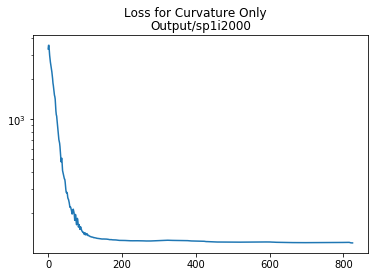

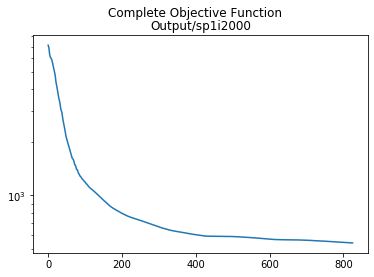

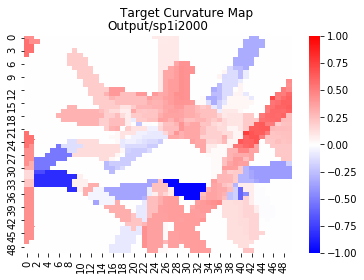

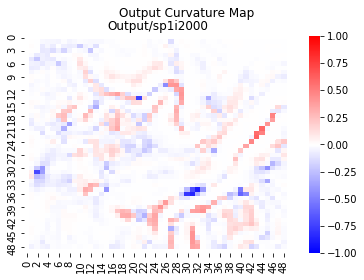

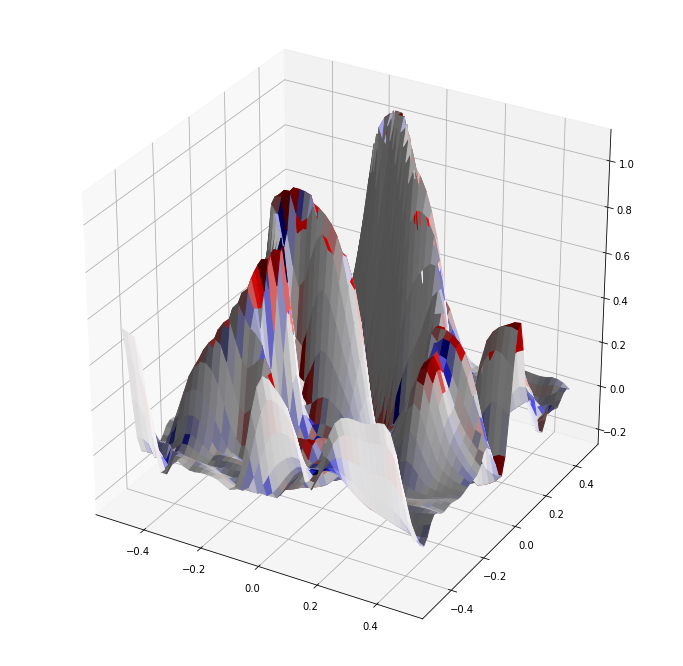

In [33]:
smooth_pen = 1
niter = 2000
momentum = 0.9
zf, cv, errvals, c_errvals = generate_surface(smooth_pen, rate, momentum, kappa, xf, yf, 
                                              t_of_v, niter = niter, verbose = True)
runname = 'Output/sp{:d}i{:d}'.format(smooth_pen, niter)
try:
    os.mkdir(runname)
except FileExistsError:
    pass
document_run(runname, zf, cv, errvals, c_errvals, kappa, gridsize)
generate_plots(runname, gridsize, xf, yf, zf, cv, 'Data/map_points.csv', refc)

starting rate setting: rate: 0.0001 obj fn: 2053.772845995889 complete obj fn: 61262.71479924858
finished rate setting: rate: 0.0001 obj fn: 2515.1018086413783 complete obj fn: 16867.41059761401
step: 0 -- lowering rate to 9.09090909090909e-05
step: 1 -- lowering rate to 8.264462809917355e-05
step: 2 -- lowering rate to 7.513148009015777e-05
step: 3 -- lowering rate to 6.830134553650706e-05
step: 4 -- lowering rate to 6.20921323059155e-05
step: 5 -- lowering rate to 5.644739300537773e-05
step: 6 -- lowering rate to 5.131581182307066e-05
step: 8 -- lowering rate to 4.665073802097332e-05
step: 9 -- lowering rate to 4.240976183724847e-05
step: 12 -- lowering rate to 3.8554328942953155e-05
step: 100, obj fn: 145.91427392500395
step: 183 -- lowering rate to 3.504938994813923e-05
step: 186 -- lowering rate to 3.1863081771035665e-05
step: 187 -- lowering rate to 2.8966437973668783e-05
step: 188 -- lowering rate to 2.633312543060798e-05
step: 189 -- lowering rate to 2.3939204936916344e-05
step

step: 329 -- lowering rate to 4.222080268017495e-11
step: 330 -- lowering rate to 3.838254789106813e-11
step: 331 -- lowering rate to 3.489322535551648e-11
step: 332 -- lowering rate to 3.172111395956043e-11
step: 333 -- lowering rate to 2.8837376326873116e-11
step: 334 -- lowering rate to 2.621579666079374e-11
step: 335 -- lowering rate to 2.3832542418903398e-11
step: 336 -- lowering rate to 2.1665947653548543e-11
step: 337 -- lowering rate to 1.9696316048680493e-11
step: 338 -- lowering rate to 1.790574186243681e-11
step: 339 -- lowering rate to 1.6277947147669826e-11
step: 340 -- lowering rate to 1.479813377060893e-11
step: 341 -- lowering rate to 1.3452848882371755e-11
step: 342 -- lowering rate to 1.2229862620337958e-11
step: 343 -- lowering rate to 1.1118056927579962e-11
step: 344 -- lowering rate to 1.0107324479618146e-11
step: 345 -- lowering rate to 9.18847679965286e-12
step: 346 -- lowering rate to 8.353160726957144e-12
step: 347 -- lowering rate to 7.593782479051949e-12
step

step: 488 -- raising rate to 1.090219609419071e-16
step: 489 -- lowering rate to 9.91108735835519e-17
step: 490 -- raising rate to 1.090219609419071e-16
step: 491 -- lowering rate to 9.91108735835519e-17
step: 492 -- raising rate to 1.090219609419071e-16
step: 493 -- lowering rate to 9.91108735835519e-17
step: 494 -- raising rate to 1.090219609419071e-16
step: 495 -- lowering rate to 9.91108735835519e-17
step: 496 -- raising rate to 1.090219609419071e-16
step: 497 -- lowering rate to 9.91108735835519e-17
step: 498 -- raising rate to 1.090219609419071e-16
step: 499 -- lowering rate to 9.91108735835519e-17
step: 500 -- raising rate to 1.090219609419071e-16
step: 501 -- lowering rate to 9.91108735835519e-17
step: 502 -- raising rate to 1.090219609419071e-16
step: 503 -- lowering rate to 9.91108735835519e-17
step: 504 -- raising rate to 1.090219609419071e-16
step: 505 -- lowering rate to 9.91108735835519e-17
step: 506 -- raising rate to 1.090219609419071e-16
step: 507 -- lowering rate to 9

step: 649 -- lowering rate to 9.91108735835519e-17
step: 650 -- raising rate to 1.090219609419071e-16
step: 651 -- lowering rate to 9.91108735835519e-17
step: 652 -- raising rate to 1.090219609419071e-16
step: 653 -- lowering rate to 9.91108735835519e-17
step: 654 -- raising rate to 1.090219609419071e-16
step: 655 -- lowering rate to 9.91108735835519e-17
step: 656 -- raising rate to 1.090219609419071e-16
step: 657 -- lowering rate to 9.91108735835519e-17
step: 658 -- raising rate to 1.090219609419071e-16
step: 659 -- lowering rate to 9.91108735835519e-17
step: 660 -- raising rate to 1.090219609419071e-16
step: 661 -- lowering rate to 9.91108735835519e-17
step: 662 -- raising rate to 1.090219609419071e-16
step: 663 -- lowering rate to 9.91108735835519e-17
step: 664 -- raising rate to 1.090219609419071e-16
step: 665 -- lowering rate to 9.91108735835519e-17
step: 666 -- raising rate to 1.090219609419071e-16
step: 667 -- lowering rate to 9.91108735835519e-17
step: 668 -- raising rate to 1.

step: 810 -- raising rate to 1.090219609419071e-16
step: 811 -- lowering rate to 9.91108735835519e-17
step: 812 -- raising rate to 1.090219609419071e-16
step: 813 -- lowering rate to 9.91108735835519e-17
step: 814 -- raising rate to 1.090219609419071e-16
step: 815 -- lowering rate to 9.91108735835519e-17
step: 816 -- raising rate to 1.090219609419071e-16
step: 817 -- lowering rate to 9.91108735835519e-17
step: 818 -- raising rate to 1.090219609419071e-16
step: 819 -- lowering rate to 9.91108735835519e-17
step: 820 -- raising rate to 1.090219609419071e-16
step: 821 -- lowering rate to 9.91108735835519e-17
step: 822 -- raising rate to 1.090219609419071e-16
step: 823 -- lowering rate to 9.91108735835519e-17
step: 824 -- raising rate to 1.090219609419071e-16
step: 825 -- lowering rate to 9.91108735835519e-17
step: 826 -- raising rate to 1.090219609419071e-16
step: 827 -- lowering rate to 9.91108735835519e-17
step: 828 -- raising rate to 1.090219609419071e-16
step: 829 -- lowering rate to 9

step: 971 -- lowering rate to 9.91108735835519e-17
step: 972 -- raising rate to 1.090219609419071e-16
step: 973 -- lowering rate to 9.91108735835519e-17
step: 974 -- raising rate to 1.090219609419071e-16
step: 975 -- lowering rate to 9.91108735835519e-17
step: 976 -- raising rate to 1.090219609419071e-16
step: 977 -- lowering rate to 9.91108735835519e-17
step: 978 -- raising rate to 1.090219609419071e-16
step: 979 -- lowering rate to 9.91108735835519e-17
step: 980 -- raising rate to 1.090219609419071e-16
step: 981 -- lowering rate to 9.91108735835519e-17
step: 982 -- raising rate to 1.090219609419071e-16
step: 983 -- lowering rate to 9.91108735835519e-17
step: 984 -- raising rate to 1.090219609419071e-16
step: 985 -- lowering rate to 9.91108735835519e-17
step: 986 -- raising rate to 1.090219609419071e-16
step: 987 -- lowering rate to 9.91108735835519e-17
step: 988 -- raising rate to 1.090219609419071e-16
step: 989 -- lowering rate to 9.91108735835519e-17
step: 990 -- raising rate to 1.

step: 1130 -- raising rate to 1.090219609419071e-16
step: 1131 -- lowering rate to 9.91108735835519e-17
step: 1132 -- raising rate to 1.090219609419071e-16
step: 1133 -- lowering rate to 9.91108735835519e-17
step: 1134 -- raising rate to 1.090219609419071e-16
step: 1135 -- lowering rate to 9.91108735835519e-17
step: 1136 -- raising rate to 1.090219609419071e-16
step: 1137 -- lowering rate to 9.91108735835519e-17
step: 1138 -- raising rate to 1.090219609419071e-16
step: 1139 -- lowering rate to 9.91108735835519e-17
step: 1140 -- raising rate to 1.090219609419071e-16
step: 1141 -- lowering rate to 9.91108735835519e-17
step: 1142 -- raising rate to 1.090219609419071e-16
step: 1143 -- lowering rate to 9.91108735835519e-17
step: 1144 -- raising rate to 1.090219609419071e-16
step: 1145 -- lowering rate to 9.91108735835519e-17
step: 1146 -- raising rate to 1.090219609419071e-16
step: 1147 -- lowering rate to 9.91108735835519e-17
step: 1148 -- raising rate to 1.090219609419071e-16
step: 1149 -

step: 1288 -- raising rate to 1.090219609419071e-16
step: 1289 -- lowering rate to 9.91108735835519e-17
step: 1290 -- raising rate to 1.090219609419071e-16
step: 1291 -- lowering rate to 9.91108735835519e-17
step: 1292 -- raising rate to 1.090219609419071e-16
step: 1293 -- lowering rate to 9.91108735835519e-17
step: 1294 -- raising rate to 1.090219609419071e-16
step: 1295 -- lowering rate to 9.91108735835519e-17
step: 1296 -- raising rate to 1.090219609419071e-16
step: 1297 -- lowering rate to 9.91108735835519e-17
step: 1298 -- raising rate to 1.090219609419071e-16
step: 1299 -- lowering rate to 9.91108735835519e-17
step: 1300 -- raising rate to 1.090219609419071e-16
step: 1301 -- lowering rate to 9.91108735835519e-17
step: 1302 -- raising rate to 1.090219609419071e-16
step: 1303 -- lowering rate to 9.91108735835519e-17
step: 1304 -- raising rate to 1.090219609419071e-16
step: 1305 -- lowering rate to 9.91108735835519e-17
step: 1306 -- raising rate to 1.090219609419071e-16
step: 1307 -

step: 1446 -- raising rate to 1.090219609419071e-16
step: 1447 -- lowering rate to 9.91108735835519e-17
step: 1448 -- raising rate to 1.090219609419071e-16
step: 1449 -- lowering rate to 9.91108735835519e-17
step: 1450 -- raising rate to 1.090219609419071e-16
step: 1451 -- lowering rate to 9.91108735835519e-17
step: 1452 -- raising rate to 1.090219609419071e-16
step: 1453 -- lowering rate to 9.91108735835519e-17
step: 1454 -- raising rate to 1.090219609419071e-16
step: 1455 -- lowering rate to 9.91108735835519e-17
step: 1456 -- raising rate to 1.090219609419071e-16
step: 1457 -- lowering rate to 9.91108735835519e-17
step: 1458 -- raising rate to 1.090219609419071e-16
step: 1459 -- lowering rate to 9.91108735835519e-17
step: 1460 -- raising rate to 1.090219609419071e-16
step: 1461 -- lowering rate to 9.91108735835519e-17
step: 1462 -- raising rate to 1.090219609419071e-16
step: 1463 -- lowering rate to 9.91108735835519e-17
step: 1464 -- raising rate to 1.090219609419071e-16
step: 1465 -

step: 1604 -- raising rate to 1.090219609419071e-16
step: 1605 -- lowering rate to 9.91108735835519e-17
step: 1606 -- raising rate to 1.090219609419071e-16
step: 1607 -- lowering rate to 9.91108735835519e-17
step: 1608 -- raising rate to 1.090219609419071e-16
step: 1609 -- lowering rate to 9.91108735835519e-17
step: 1610 -- raising rate to 1.090219609419071e-16
step: 1611 -- lowering rate to 9.91108735835519e-17
step: 1612 -- raising rate to 1.090219609419071e-16
step: 1613 -- lowering rate to 9.91108735835519e-17
step: 1614 -- raising rate to 1.090219609419071e-16
step: 1615 -- lowering rate to 9.91108735835519e-17
step: 1616 -- raising rate to 1.090219609419071e-16
step: 1617 -- lowering rate to 9.91108735835519e-17
step: 1618 -- raising rate to 1.090219609419071e-16
step: 1619 -- lowering rate to 9.91108735835519e-17
step: 1620 -- raising rate to 1.090219609419071e-16
step: 1621 -- lowering rate to 9.91108735835519e-17
step: 1622 -- raising rate to 1.090219609419071e-16
step: 1623 -

step: 1762 -- raising rate to 1.090219609419071e-16
step: 1763 -- lowering rate to 9.91108735835519e-17
step: 1764 -- raising rate to 1.090219609419071e-16
step: 1765 -- lowering rate to 9.91108735835519e-17
step: 1766 -- raising rate to 1.090219609419071e-16
step: 1767 -- lowering rate to 9.91108735835519e-17
step: 1768 -- raising rate to 1.090219609419071e-16
step: 1769 -- lowering rate to 9.91108735835519e-17
step: 1770 -- raising rate to 1.090219609419071e-16
step: 1771 -- lowering rate to 9.91108735835519e-17
step: 1772 -- raising rate to 1.090219609419071e-16
step: 1773 -- lowering rate to 9.91108735835519e-17
step: 1774 -- raising rate to 1.090219609419071e-16
step: 1775 -- lowering rate to 9.91108735835519e-17
step: 1776 -- raising rate to 1.090219609419071e-16
step: 1777 -- lowering rate to 9.91108735835519e-17
step: 1778 -- raising rate to 1.090219609419071e-16
step: 1779 -- lowering rate to 9.91108735835519e-17
step: 1780 -- raising rate to 1.090219609419071e-16
step: 1781 -

step: 1920 -- raising rate to 1.090219609419071e-16
step: 1921 -- lowering rate to 9.91108735835519e-17
step: 1922 -- raising rate to 1.090219609419071e-16
step: 1923 -- lowering rate to 9.91108735835519e-17
step: 1924 -- raising rate to 1.090219609419071e-16
step: 1925 -- lowering rate to 9.91108735835519e-17
step: 1926 -- raising rate to 1.090219609419071e-16
step: 1927 -- lowering rate to 9.91108735835519e-17
step: 1928 -- raising rate to 1.090219609419071e-16
step: 1929 -- lowering rate to 9.91108735835519e-17
step: 1930 -- raising rate to 1.090219609419071e-16
step: 1931 -- lowering rate to 9.91108735835519e-17
step: 1932 -- raising rate to 1.090219609419071e-16
step: 1933 -- lowering rate to 9.91108735835519e-17
step: 1934 -- raising rate to 1.090219609419071e-16
step: 1935 -- lowering rate to 9.91108735835519e-17
step: 1936 -- raising rate to 1.090219609419071e-16
step: 1937 -- lowering rate to 9.91108735835519e-17
step: 1938 -- raising rate to 1.090219609419071e-16
step: 1939 -

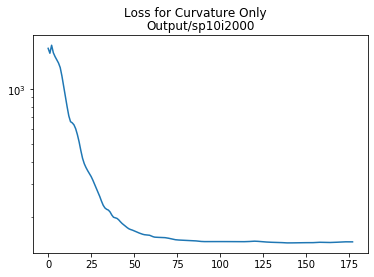

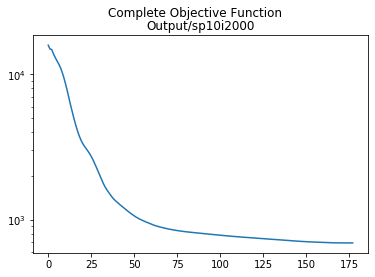

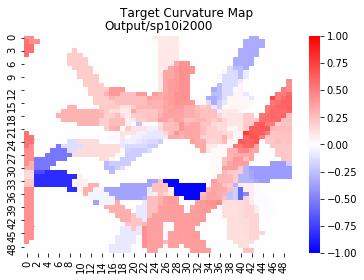

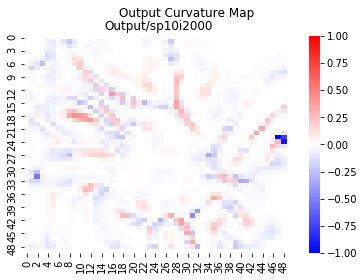

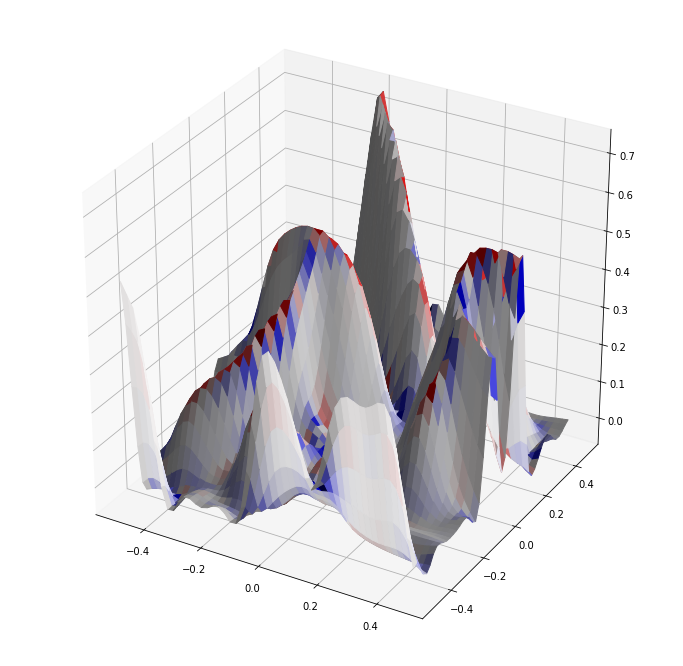

In [34]:
smooth_pen = 10
niter = 2000
momentum = 0.9
zf, cv, errvals, c_errvals = generate_surface(smooth_pen, rate, momentum, kappa, xf, yf, 
                                              t_of_v, niter = niter, verbose = True)
runname = 'Output/sp{:d}i{:d}'.format(smooth_pen, niter)
try:
    os.mkdir(runname)
except FileExistsError:
    pass
document_run(runname, zf, cv, errvals, c_errvals, kappa, gridsize)
generate_plots(runname, gridsize, xf, yf, zf, cv, 'Data/map_points.csv', refc)

starting rate setting: rate: 0.0001 obj fn: 2053.772845995889 complete obj fn: 7974.667041321158
finished rate setting: rate: 0.0001 obj fn: 2784.039260670277 complete obj fn: 7228.231388473303
step: 0, obj fn: 2055.2290861952233
step: 10 -- lowering rate to 9.09090909090909e-05
step: 20 -- lowering rate to 8.264462809917355e-05
step: 23 -- lowering rate to 7.513148009015777e-05
step: 25 -- lowering rate to 6.830134553650706e-05
step: 29 -- lowering rate to 6.20921323059155e-05
step: 32 -- lowering rate to 5.644739300537773e-05
step: 35 -- lowering rate to 5.131581182307066e-05
step: 37 -- lowering rate to 4.665073802097332e-05
step: 39 -- lowering rate to 4.240976183724847e-05
step: 41 -- lowering rate to 3.8554328942953155e-05
step: 43 -- lowering rate to 3.504938994813923e-05
step: 45 -- lowering rate to 3.1863081771035665e-05
step: 47 -- lowering rate to 2.8966437973668783e-05
step: 49 -- lowering rate to 2.633312543060798e-05
step: 51 -- lowering rate to 2.3939204936916344e-05
ste

step: 198 -- lowering rate to 3.838254789106813e-11
step: 199 -- lowering rate to 3.489322535551648e-11
step: 200 -- lowering rate to 3.172111395956043e-11
step: 201 -- lowering rate to 2.8837376326873116e-11
step: 202 -- lowering rate to 2.621579666079374e-11
step: 203 -- lowering rate to 2.3832542418903398e-11
step: 204 -- lowering rate to 2.1665947653548543e-11
step: 205 -- lowering rate to 1.9696316048680493e-11
step: 206 -- lowering rate to 1.790574186243681e-11
step: 207 -- lowering rate to 1.6277947147669826e-11
step: 208 -- lowering rate to 1.479813377060893e-11
step: 209 -- lowering rate to 1.3452848882371755e-11
step: 210 -- lowering rate to 1.2229862620337958e-11
step: 211 -- lowering rate to 1.1118056927579962e-11
step: 212 -- lowering rate to 1.0107324479618146e-11
step: 213 -- lowering rate to 9.18847679965286e-12
step: 214 -- lowering rate to 8.353160726957144e-12
step: 215 -- lowering rate to 7.593782479051949e-12
step: 216 -- lowering rate to 6.903438617319953e-12
step

step: 355 -- lowering rate to 1.2175371757108585e-17
step: 356 -- lowering rate to 1.1068519779189621e-17
step: 357 -- lowering rate to 1.00622907083542e-17
step: 358 -- lowering rate to 9.147537007594726e-18
step: 359 -- lowering rate to 8.315942734177023e-18
step: 360 -- lowering rate to 7.559947940160929e-18
step: 361 -- lowering rate to 6.872679945600844e-18
step: 362 -- lowering rate to 6.2478908596371304e-18
step: 363 -- lowering rate to 5.6799007814883e-18
step: 364 -- lowering rate to 5.163546164989363e-18
step: 365 -- lowering rate to 4.694132877263057e-18
step: 366 -- lowering rate to 4.267393524784597e-18
step: 367 -- lowering rate to 3.879448658895088e-18
step: 368 -- lowering rate to 3.526771508086443e-18
step: 369 -- lowering rate to 3.206155916442221e-18
step: 370 -- lowering rate to 2.9146871967656555e-18
step: 371 -- lowering rate to 2.649715633423323e-18
step: 372 -- lowering rate to 2.4088323940212025e-18
step: 373 -- lowering rate to 2.1898476309283657e-18
step: 374

step: 514 -- raising rate to 6.343208557307202e-19
step: 515 -- lowering rate to 5.766553233915637e-19
step: 516 -- raising rate to 6.343208557307202e-19
step: 517 -- lowering rate to 5.766553233915637e-19
step: 518 -- raising rate to 6.343208557307202e-19
step: 519 -- lowering rate to 5.766553233915637e-19
step: 520 -- raising rate to 6.343208557307202e-19
step: 521 -- lowering rate to 5.766553233915637e-19
step: 522 -- raising rate to 6.343208557307202e-19
step: 523 -- lowering rate to 5.766553233915637e-19
step: 524 -- raising rate to 6.343208557307202e-19
step: 525 -- lowering rate to 5.766553233915637e-19
step: 526 -- raising rate to 6.343208557307202e-19
step: 527 -- lowering rate to 5.766553233915637e-19
step: 528 -- raising rate to 6.343208557307202e-19
step: 529 -- lowering rate to 5.766553233915637e-19
step: 530 -- raising rate to 6.343208557307202e-19
step: 531 -- lowering rate to 5.766553233915637e-19
step: 532 -- raising rate to 6.343208557307202e-19
step: 533 -- lowering 

step: 674 -- raising rate to 6.343208557307202e-19
step: 675 -- lowering rate to 5.766553233915637e-19
step: 676 -- raising rate to 6.343208557307202e-19
step: 677 -- lowering rate to 5.766553233915637e-19
step: 678 -- raising rate to 6.343208557307202e-19
step: 679 -- lowering rate to 5.766553233915637e-19
step: 680 -- raising rate to 6.343208557307202e-19
step: 681 -- lowering rate to 5.766553233915637e-19
step: 682 -- raising rate to 6.343208557307202e-19
step: 683 -- lowering rate to 5.766553233915637e-19
step: 684 -- raising rate to 6.343208557307202e-19
step: 685 -- lowering rate to 5.766553233915637e-19
step: 686 -- raising rate to 6.343208557307202e-19
step: 687 -- lowering rate to 5.766553233915637e-19
step: 688 -- raising rate to 6.343208557307202e-19
step: 689 -- lowering rate to 5.766553233915637e-19
step: 690 -- raising rate to 6.343208557307202e-19
step: 691 -- lowering rate to 5.766553233915637e-19
step: 692 -- raising rate to 6.343208557307202e-19
step: 693 -- lowering 

step: 834 -- raising rate to 6.343208557307202e-19
step: 835 -- lowering rate to 5.766553233915637e-19
step: 836 -- raising rate to 6.343208557307202e-19
step: 837 -- lowering rate to 5.766553233915637e-19
step: 838 -- raising rate to 6.343208557307202e-19
step: 839 -- lowering rate to 5.766553233915637e-19
step: 840 -- raising rate to 6.343208557307202e-19
step: 841 -- lowering rate to 5.766553233915637e-19
step: 842 -- raising rate to 6.343208557307202e-19
step: 843 -- lowering rate to 5.766553233915637e-19
step: 844 -- raising rate to 6.343208557307202e-19
step: 845 -- lowering rate to 5.766553233915637e-19
step: 846 -- raising rate to 6.343208557307202e-19
step: 847 -- lowering rate to 5.766553233915637e-19
step: 848 -- raising rate to 6.343208557307202e-19
step: 849 -- lowering rate to 5.766553233915637e-19
step: 850 -- raising rate to 6.343208557307202e-19
step: 851 -- lowering rate to 5.766553233915637e-19
step: 852 -- raising rate to 6.343208557307202e-19
step: 853 -- lowering 

step: 994 -- raising rate to 6.343208557307202e-19
step: 995 -- lowering rate to 5.766553233915637e-19
step: 996 -- raising rate to 6.343208557307202e-19
step: 997 -- lowering rate to 5.766553233915637e-19
step: 998 -- raising rate to 6.343208557307202e-19
step: 999 -- lowering rate to 5.766553233915637e-19
Done: final error: 152.48503061154636


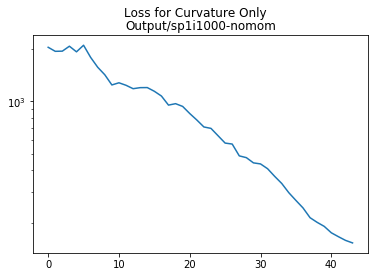

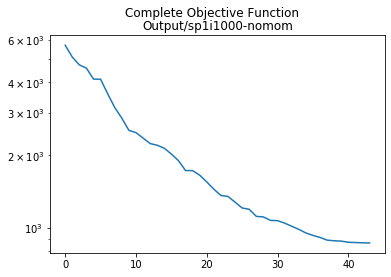

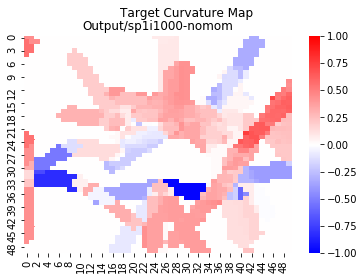

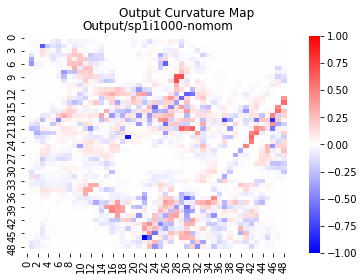

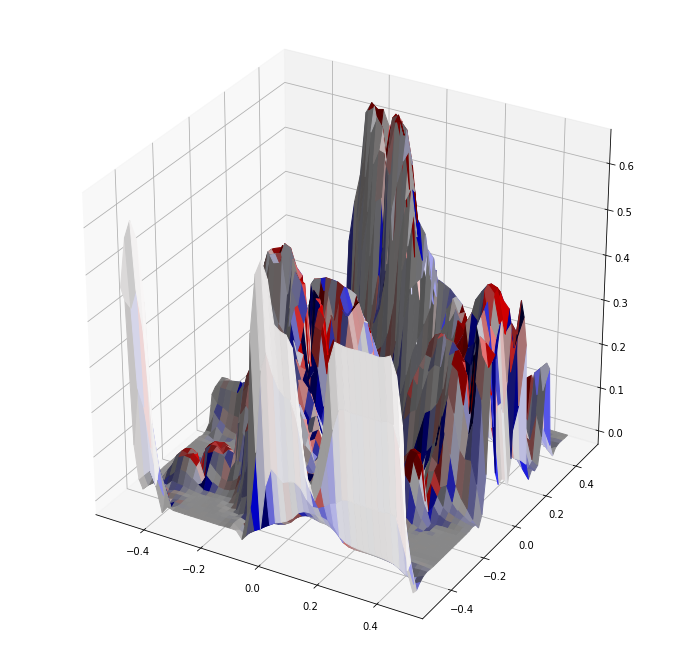

In [35]:
smooth_pen = 1
niter = 1000
momentum = 0
zf, cv, errvals, c_errvals = generate_surface(smooth_pen, rate, momentum, kappa, xf, yf, 
                                              t_of_v, niter = niter, verbose = True)
runname = 'Output/sp{:d}i{:d}-nomom'.format(smooth_pen, niter)
try:
    os.mkdir(runname)
except FileExistsError:
    pass
document_run(runname, zf, cv, errvals, c_errvals, kappa, gridsize)
generate_plots(runname, gridsize, xf, yf, zf, cv, 'Data/map_points.csv', refc)

starting rate setting: rate: 0.0001 obj fn: 2053.772845995889 complete obj fn: 2645.8622655284157
setup: -- lowering rate to 9.09090909090909e-05
setup: -- lowering rate to 8.264462809917355e-05
setup: -- lowering rate to 7.513148009015777e-05
setup: -- lowering rate to 6.830134553650706e-05
finished rate setting: rate: 6.830134553650706e-05 obj fn: 1940.0261415938526 complete obj fn: 2477.2042547020837
step: 0 -- lowering rate to 6.20921323059155e-05
step: 1 -- lowering rate to 5.644739300537773e-05
step: 2 -- lowering rate to 5.131581182307066e-05
step: 3 -- lowering rate to 4.665073802097332e-05
step: 4 -- lowering rate to 4.240976183724847e-05
step: 9 -- lowering rate to 3.8554328942953155e-05
step: 35 -- lowering rate to 3.504938994813923e-05
step: 38 -- lowering rate to 3.1863081771035665e-05
step: 41 -- lowering rate to 2.8966437973668783e-05
step: 44 -- lowering rate to 2.633312543060798e-05
step: 47 -- lowering rate to 2.3939204936916344e-05
step: 50 -- lowering rate to 2.1762

step: 213 -- lowering rate to 3.838254789106813e-11
step: 214 -- lowering rate to 3.489322535551648e-11
step: 215 -- lowering rate to 3.172111395956043e-11
step: 216 -- lowering rate to 2.8837376326873116e-11
step: 217 -- lowering rate to 2.621579666079374e-11
step: 218 -- lowering rate to 2.3832542418903398e-11
step: 219 -- lowering rate to 2.1665947653548543e-11
step: 220 -- lowering rate to 1.9696316048680493e-11
step: 221 -- lowering rate to 1.790574186243681e-11
step: 222 -- lowering rate to 1.6277947147669826e-11
step: 223 -- lowering rate to 1.479813377060893e-11
step: 224 -- lowering rate to 1.3452848882371755e-11
step: 225 -- lowering rate to 1.2229862620337958e-11
step: 226 -- lowering rate to 1.1118056927579962e-11
step: 227 -- lowering rate to 1.0107324479618146e-11
step: 228 -- lowering rate to 9.18847679965286e-12
step: 229 -- lowering rate to 8.353160726957144e-12
step: 230 -- lowering rate to 7.593782479051949e-12
step: 231 -- lowering rate to 6.903438617319953e-12
step

step: 370 -- lowering rate to 5.594550432277063e-17
step: 371 -- raising rate to 6.15400547550477e-17
step: 372 -- lowering rate to 5.594550432277063e-17
step: 373 -- raising rate to 6.15400547550477e-17
step: 374 -- lowering rate to 5.594550432277063e-17
step: 375 -- raising rate to 6.15400547550477e-17
step: 376 -- lowering rate to 5.594550432277063e-17
step: 377 -- raising rate to 6.15400547550477e-17
step: 378 -- lowering rate to 5.594550432277063e-17
step: 379 -- raising rate to 6.15400547550477e-17
step: 380 -- lowering rate to 5.594550432277063e-17
step: 381 -- raising rate to 6.15400547550477e-17
step: 382 -- lowering rate to 5.594550432277063e-17
step: 383 -- raising rate to 6.15400547550477e-17
step: 384 -- lowering rate to 5.594550432277063e-17
step: 385 -- raising rate to 6.15400547550477e-17
step: 386 -- lowering rate to 5.594550432277063e-17
step: 387 -- raising rate to 6.15400547550477e-17
step: 388 -- lowering rate to 5.594550432277063e-17
step: 389 -- raising rate to 6

step: 531 -- raising rate to 6.15400547550477e-17
step: 532 -- lowering rate to 5.594550432277063e-17
step: 533 -- raising rate to 6.15400547550477e-17
step: 534 -- lowering rate to 5.594550432277063e-17
step: 535 -- raising rate to 6.15400547550477e-17
step: 536 -- lowering rate to 5.594550432277063e-17
step: 537 -- raising rate to 6.15400547550477e-17
step: 538 -- lowering rate to 5.594550432277063e-17
step: 539 -- raising rate to 6.15400547550477e-17
step: 540 -- lowering rate to 5.594550432277063e-17
step: 541 -- raising rate to 6.15400547550477e-17
step: 542 -- lowering rate to 5.594550432277063e-17
step: 543 -- raising rate to 6.15400547550477e-17
step: 544 -- lowering rate to 5.594550432277063e-17
step: 545 -- raising rate to 6.15400547550477e-17
step: 546 -- lowering rate to 5.594550432277063e-17
step: 547 -- raising rate to 6.15400547550477e-17
step: 548 -- lowering rate to 5.594550432277063e-17
step: 549 -- raising rate to 6.15400547550477e-17
step: 550 -- lowering rate to 5.

step: 692 -- lowering rate to 5.594550432277063e-17
step: 693 -- raising rate to 6.15400547550477e-17
step: 694 -- lowering rate to 5.594550432277063e-17
step: 695 -- raising rate to 6.15400547550477e-17
step: 696 -- lowering rate to 5.594550432277063e-17
step: 697 -- raising rate to 6.15400547550477e-17
step: 698 -- lowering rate to 5.594550432277063e-17
step: 699 -- raising rate to 6.15400547550477e-17
step: 700 -- lowering rate to 5.594550432277063e-17
step: 701 -- raising rate to 6.15400547550477e-17
step: 702 -- lowering rate to 5.594550432277063e-17
step: 703 -- raising rate to 6.15400547550477e-17
step: 704 -- lowering rate to 5.594550432277063e-17
step: 705 -- raising rate to 6.15400547550477e-17
step: 706 -- lowering rate to 5.594550432277063e-17
step: 707 -- raising rate to 6.15400547550477e-17
step: 708 -- lowering rate to 5.594550432277063e-17
step: 709 -- raising rate to 6.15400547550477e-17
step: 710 -- lowering rate to 5.594550432277063e-17
step: 711 -- raising rate to 6

step: 853 -- raising rate to 6.15400547550477e-17
step: 854 -- lowering rate to 5.594550432277063e-17
step: 855 -- raising rate to 6.15400547550477e-17
step: 856 -- lowering rate to 5.594550432277063e-17
step: 857 -- raising rate to 6.15400547550477e-17
step: 858 -- lowering rate to 5.594550432277063e-17
step: 859 -- raising rate to 6.15400547550477e-17
step: 860 -- lowering rate to 5.594550432277063e-17
step: 861 -- raising rate to 6.15400547550477e-17
step: 862 -- lowering rate to 5.594550432277063e-17
step: 863 -- raising rate to 6.15400547550477e-17
step: 864 -- lowering rate to 5.594550432277063e-17
step: 865 -- raising rate to 6.15400547550477e-17
step: 866 -- lowering rate to 5.594550432277063e-17
step: 867 -- raising rate to 6.15400547550477e-17
step: 868 -- lowering rate to 5.594550432277063e-17
step: 869 -- raising rate to 6.15400547550477e-17
step: 870 -- lowering rate to 5.594550432277063e-17
step: 871 -- raising rate to 6.15400547550477e-17
step: 872 -- lowering rate to 5.

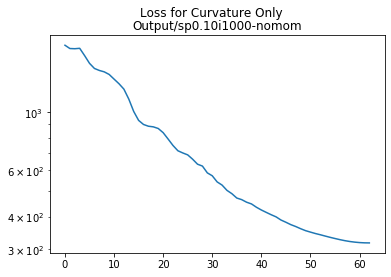

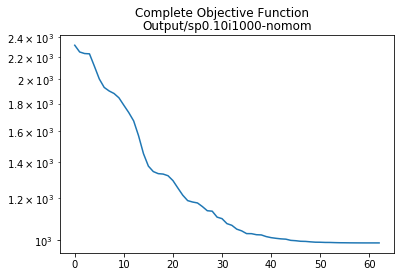

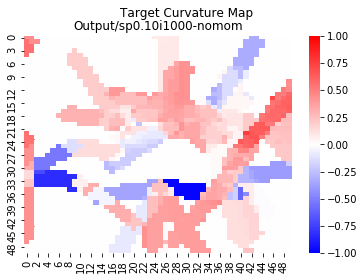

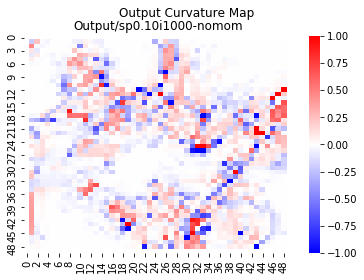

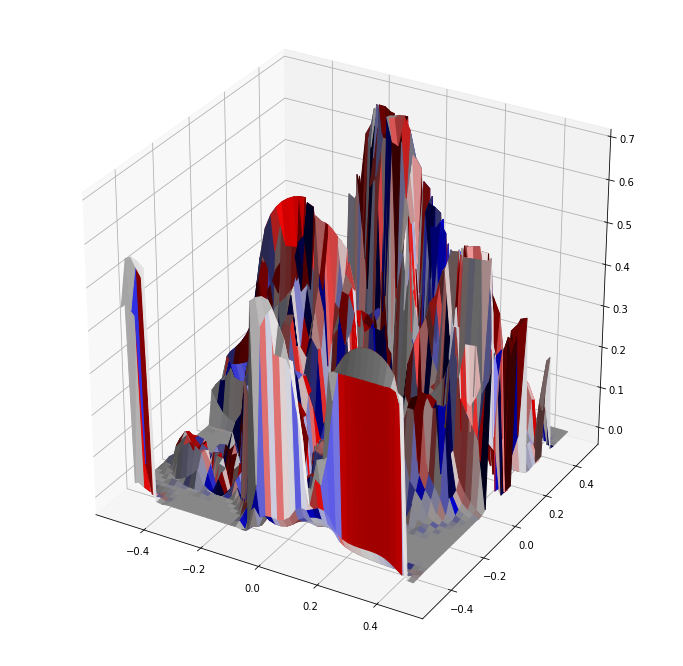

In [39]:
smooth_pen = 0.1
niter = 1000
momentum = 0.9
zf, cv, errvals, c_errvals = generate_surface(smooth_pen, rate, momentum, kappa, xf, yf, 
                                              t_of_v, niter = niter, verbose = True)
runname = 'Output/sp{:.2f}i{:d}-nomom'.format(smooth_pen, niter)
try:
    os.mkdir(runname)
except FileExistsError:
    pass
document_run(runname, zf, cv, errvals, c_errvals, kappa, gridsize)
generate_plots(runname, gridsize, xf, yf, zf, cv, 'Data/map_points.csv', refc)

starting rate setting: rate: 0.0001 obj fn: 2053.772845995889 complete obj fn: 594143.1923785227
setup: -- lowering rate to 9.09090909090909e-05
setup: -- lowering rate to 8.264462809917355e-05
setup: -- lowering rate to 7.513148009015777e-05
setup: -- lowering rate to 6.830134553650706e-05
setup: -- lowering rate to 6.20921323059155e-05
setup: -- lowering rate to 5.644739300537773e-05
setup: -- lowering rate to 5.131581182307066e-05
setup: -- lowering rate to 4.665073802097332e-05
setup: -- lowering rate to 4.240976183724847e-05
setup: -- lowering rate to 3.8554328942953155e-05
setup: -- lowering rate to 3.504938994813923e-05
setup: -- lowering rate to 3.1863081771035665e-05
setup: -- lowering rate to 2.8966437973668783e-05
setup: -- lowering rate to 2.633312543060798e-05
setup: -- lowering rate to 2.3939204936916344e-05
setup: -- lowering rate to 2.1762913579014857e-05
setup: -- lowering rate to 1.9784466890013503e-05
setup: -- lowering rate to 1.7985878990921365e-05
finished rate se

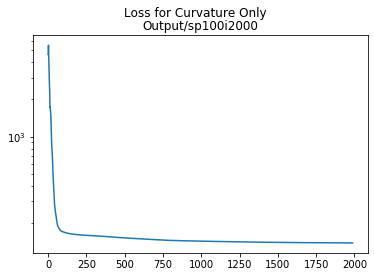

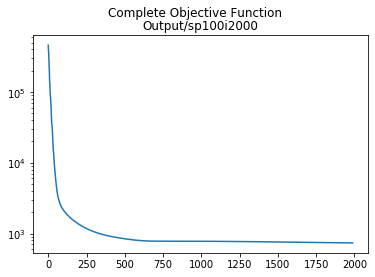

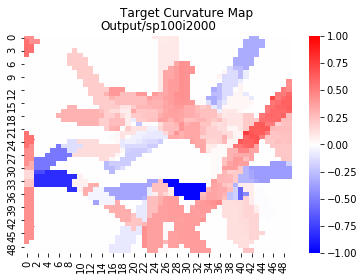

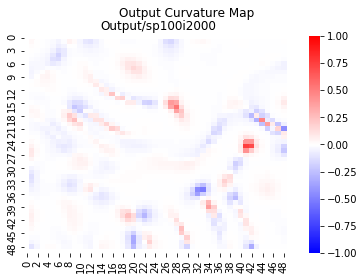

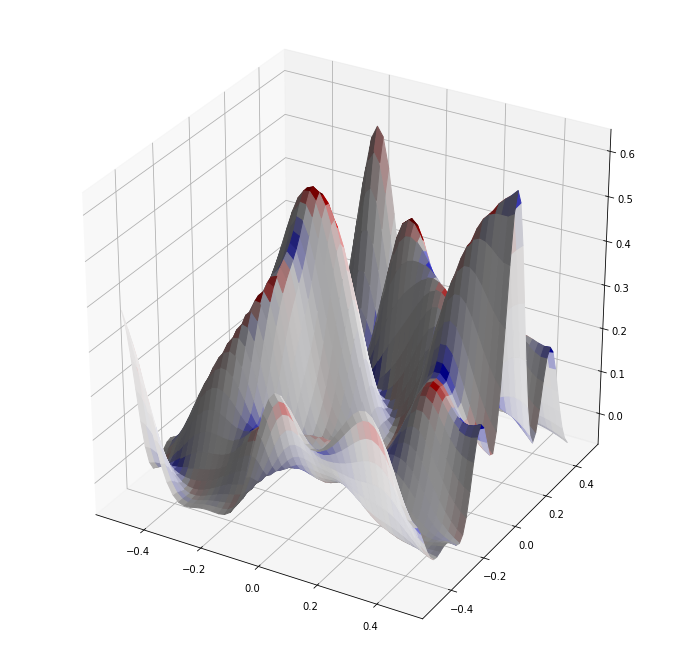

In [40]:
smooth_pen = 100
niter = 2000
momentum = 0.9
zf, cv, errvals, c_errvals = generate_surface(smooth_pen, rate, momentum, kappa, xf, yf, 
                                              t_of_v, niter = niter, verbose = True)
runname = 'Output/sp{:d}i{:d}'.format(smooth_pen, niter)
try:
    os.mkdir(runname)
except FileExistsError:
    pass
document_run(runname, zf, cv, errvals, c_errvals, kappa, gridsize)
generate_plots(runname, gridsize, xf, yf, zf, cv, 'Data/map_points.csv', refc)

starting rate setting: rate: 0.0001 obj fn: 2053.772845995889 complete obj fn: 61262.71479924858
finished rate setting: rate: 0.0001 obj fn: 2515.1018086413783 complete obj fn: 16867.41059761401
step: 0 -- lowering rate to 9.09090909090909e-05
step: 1 -- lowering rate to 8.264462809917355e-05
step: 2 -- lowering rate to 7.513148009015777e-05
step: 3 -- lowering rate to 6.830134553650706e-05
step: 4 -- lowering rate to 6.20921323059155e-05
step: 5 -- lowering rate to 5.644739300537773e-05
step: 6 -- lowering rate to 5.131581182307066e-05
step: 8 -- lowering rate to 4.665073802097332e-05
step: 9 -- lowering rate to 4.240976183724847e-05
step: 12 -- lowering rate to 3.8554328942953155e-05
step: 100, obj fn: 145.91427392500395
step: 183 -- lowering rate to 3.504938994813923e-05
step: 186 -- lowering rate to 3.1863081771035665e-05
step: 187 -- lowering rate to 2.8966437973668783e-05
step: 188 -- lowering rate to 2.633312543060798e-05
step: 189 -- lowering rate to 2.3939204936916344e-05
step

step: 329 -- lowering rate to 4.222080268017495e-11
step: 330 -- lowering rate to 3.838254789106813e-11
step: 331 -- lowering rate to 3.489322535551648e-11
step: 332 -- lowering rate to 3.172111395956043e-11
step: 333 -- lowering rate to 2.8837376326873116e-11
step: 334 -- lowering rate to 2.621579666079374e-11
step: 335 -- lowering rate to 2.3832542418903398e-11
step: 336 -- lowering rate to 2.1665947653548543e-11
step: 337 -- lowering rate to 1.9696316048680493e-11
step: 338 -- lowering rate to 1.790574186243681e-11
step: 339 -- lowering rate to 1.6277947147669826e-11
step: 340 -- lowering rate to 1.479813377060893e-11
step: 341 -- lowering rate to 1.3452848882371755e-11
step: 342 -- lowering rate to 1.2229862620337958e-11
step: 343 -- lowering rate to 1.1118056927579962e-11
step: 344 -- lowering rate to 1.0107324479618146e-11
step: 345 -- lowering rate to 9.18847679965286e-12
step: 346 -- lowering rate to 8.353160726957144e-12
step: 347 -- lowering rate to 7.593782479051949e-12
step

step: 488 -- raising rate to 1.090219609419071e-16
step: 489 -- lowering rate to 9.91108735835519e-17
step: 490 -- raising rate to 1.090219609419071e-16
step: 491 -- lowering rate to 9.91108735835519e-17
step: 492 -- raising rate to 1.090219609419071e-16
step: 493 -- lowering rate to 9.91108735835519e-17
step: 494 -- raising rate to 1.090219609419071e-16
step: 495 -- lowering rate to 9.91108735835519e-17
step: 496 -- raising rate to 1.090219609419071e-16
step: 497 -- lowering rate to 9.91108735835519e-17
step: 498 -- raising rate to 1.090219609419071e-16
step: 499 -- lowering rate to 9.91108735835519e-17
step: 500 -- raising rate to 1.090219609419071e-16
step: 501 -- lowering rate to 9.91108735835519e-17
step: 502 -- raising rate to 1.090219609419071e-16
step: 503 -- lowering rate to 9.91108735835519e-17
step: 504 -- raising rate to 1.090219609419071e-16
step: 505 -- lowering rate to 9.91108735835519e-17
step: 506 -- raising rate to 1.090219609419071e-16
step: 507 -- lowering rate to 9

step: 649 -- lowering rate to 9.91108735835519e-17
step: 650 -- raising rate to 1.090219609419071e-16
step: 651 -- lowering rate to 9.91108735835519e-17
step: 652 -- raising rate to 1.090219609419071e-16
step: 653 -- lowering rate to 9.91108735835519e-17
step: 654 -- raising rate to 1.090219609419071e-16
step: 655 -- lowering rate to 9.91108735835519e-17
step: 656 -- raising rate to 1.090219609419071e-16
step: 657 -- lowering rate to 9.91108735835519e-17
step: 658 -- raising rate to 1.090219609419071e-16
step: 659 -- lowering rate to 9.91108735835519e-17
step: 660 -- raising rate to 1.090219609419071e-16
step: 661 -- lowering rate to 9.91108735835519e-17
step: 662 -- raising rate to 1.090219609419071e-16
step: 663 -- lowering rate to 9.91108735835519e-17
step: 664 -- raising rate to 1.090219609419071e-16
step: 665 -- lowering rate to 9.91108735835519e-17
step: 666 -- raising rate to 1.090219609419071e-16
step: 667 -- lowering rate to 9.91108735835519e-17
step: 668 -- raising rate to 1.

step: 810 -- raising rate to 1.090219609419071e-16
step: 811 -- lowering rate to 9.91108735835519e-17
step: 812 -- raising rate to 1.090219609419071e-16
step: 813 -- lowering rate to 9.91108735835519e-17
step: 814 -- raising rate to 1.090219609419071e-16
step: 815 -- lowering rate to 9.91108735835519e-17
step: 816 -- raising rate to 1.090219609419071e-16
step: 817 -- lowering rate to 9.91108735835519e-17
step: 818 -- raising rate to 1.090219609419071e-16
step: 819 -- lowering rate to 9.91108735835519e-17
step: 820 -- raising rate to 1.090219609419071e-16
step: 821 -- lowering rate to 9.91108735835519e-17
step: 822 -- raising rate to 1.090219609419071e-16
step: 823 -- lowering rate to 9.91108735835519e-17
step: 824 -- raising rate to 1.090219609419071e-16
step: 825 -- lowering rate to 9.91108735835519e-17
step: 826 -- raising rate to 1.090219609419071e-16
step: 827 -- lowering rate to 9.91108735835519e-17
step: 828 -- raising rate to 1.090219609419071e-16
step: 829 -- lowering rate to 9

step: 971 -- lowering rate to 9.91108735835519e-17
step: 972 -- raising rate to 1.090219609419071e-16
step: 973 -- lowering rate to 9.91108735835519e-17
step: 974 -- raising rate to 1.090219609419071e-16
step: 975 -- lowering rate to 9.91108735835519e-17
step: 976 -- raising rate to 1.090219609419071e-16
step: 977 -- lowering rate to 9.91108735835519e-17
step: 978 -- raising rate to 1.090219609419071e-16
step: 979 -- lowering rate to 9.91108735835519e-17
step: 980 -- raising rate to 1.090219609419071e-16
step: 981 -- lowering rate to 9.91108735835519e-17
step: 982 -- raising rate to 1.090219609419071e-16
step: 983 -- lowering rate to 9.91108735835519e-17
step: 984 -- raising rate to 1.090219609419071e-16
step: 985 -- lowering rate to 9.91108735835519e-17
step: 986 -- raising rate to 1.090219609419071e-16
step: 987 -- lowering rate to 9.91108735835519e-17
step: 988 -- raising rate to 1.090219609419071e-16
step: 989 -- lowering rate to 9.91108735835519e-17
step: 990 -- raising rate to 1.

step: 1130 -- raising rate to 1.090219609419071e-16
step: 1131 -- lowering rate to 9.91108735835519e-17
step: 1132 -- raising rate to 1.090219609419071e-16
step: 1133 -- lowering rate to 9.91108735835519e-17
step: 1134 -- raising rate to 1.090219609419071e-16
step: 1135 -- lowering rate to 9.91108735835519e-17
step: 1136 -- raising rate to 1.090219609419071e-16
step: 1137 -- lowering rate to 9.91108735835519e-17
step: 1138 -- raising rate to 1.090219609419071e-16
step: 1139 -- lowering rate to 9.91108735835519e-17
step: 1140 -- raising rate to 1.090219609419071e-16
step: 1141 -- lowering rate to 9.91108735835519e-17
step: 1142 -- raising rate to 1.090219609419071e-16
step: 1143 -- lowering rate to 9.91108735835519e-17
step: 1144 -- raising rate to 1.090219609419071e-16
step: 1145 -- lowering rate to 9.91108735835519e-17
step: 1146 -- raising rate to 1.090219609419071e-16
step: 1147 -- lowering rate to 9.91108735835519e-17
step: 1148 -- raising rate to 1.090219609419071e-16
step: 1149 -

step: 1288 -- raising rate to 1.090219609419071e-16
step: 1289 -- lowering rate to 9.91108735835519e-17
step: 1290 -- raising rate to 1.090219609419071e-16
step: 1291 -- lowering rate to 9.91108735835519e-17
step: 1292 -- raising rate to 1.090219609419071e-16
step: 1293 -- lowering rate to 9.91108735835519e-17
step: 1294 -- raising rate to 1.090219609419071e-16
step: 1295 -- lowering rate to 9.91108735835519e-17
step: 1296 -- raising rate to 1.090219609419071e-16
step: 1297 -- lowering rate to 9.91108735835519e-17
step: 1298 -- raising rate to 1.090219609419071e-16
step: 1299 -- lowering rate to 9.91108735835519e-17
step: 1300 -- raising rate to 1.090219609419071e-16
step: 1301 -- lowering rate to 9.91108735835519e-17
step: 1302 -- raising rate to 1.090219609419071e-16
step: 1303 -- lowering rate to 9.91108735835519e-17
step: 1304 -- raising rate to 1.090219609419071e-16
step: 1305 -- lowering rate to 9.91108735835519e-17
step: 1306 -- raising rate to 1.090219609419071e-16
step: 1307 -

step: 1446 -- raising rate to 1.090219609419071e-16
step: 1447 -- lowering rate to 9.91108735835519e-17
step: 1448 -- raising rate to 1.090219609419071e-16
step: 1449 -- lowering rate to 9.91108735835519e-17
step: 1450 -- raising rate to 1.090219609419071e-16
step: 1451 -- lowering rate to 9.91108735835519e-17
step: 1452 -- raising rate to 1.090219609419071e-16
step: 1453 -- lowering rate to 9.91108735835519e-17
step: 1454 -- raising rate to 1.090219609419071e-16
step: 1455 -- lowering rate to 9.91108735835519e-17
step: 1456 -- raising rate to 1.090219609419071e-16
step: 1457 -- lowering rate to 9.91108735835519e-17
step: 1458 -- raising rate to 1.090219609419071e-16
step: 1459 -- lowering rate to 9.91108735835519e-17
step: 1460 -- raising rate to 1.090219609419071e-16
step: 1461 -- lowering rate to 9.91108735835519e-17
step: 1462 -- raising rate to 1.090219609419071e-16
step: 1463 -- lowering rate to 9.91108735835519e-17
step: 1464 -- raising rate to 1.090219609419071e-16
step: 1465 -

step: 1604 -- raising rate to 1.090219609419071e-16
step: 1605 -- lowering rate to 9.91108735835519e-17
step: 1606 -- raising rate to 1.090219609419071e-16
step: 1607 -- lowering rate to 9.91108735835519e-17
step: 1608 -- raising rate to 1.090219609419071e-16
step: 1609 -- lowering rate to 9.91108735835519e-17
step: 1610 -- raising rate to 1.090219609419071e-16
step: 1611 -- lowering rate to 9.91108735835519e-17
step: 1612 -- raising rate to 1.090219609419071e-16
step: 1613 -- lowering rate to 9.91108735835519e-17
step: 1614 -- raising rate to 1.090219609419071e-16
step: 1615 -- lowering rate to 9.91108735835519e-17
step: 1616 -- raising rate to 1.090219609419071e-16
step: 1617 -- lowering rate to 9.91108735835519e-17
step: 1618 -- raising rate to 1.090219609419071e-16
step: 1619 -- lowering rate to 9.91108735835519e-17
step: 1620 -- raising rate to 1.090219609419071e-16
step: 1621 -- lowering rate to 9.91108735835519e-17
step: 1622 -- raising rate to 1.090219609419071e-16
step: 1623 -

step: 1762 -- raising rate to 1.090219609419071e-16
step: 1763 -- lowering rate to 9.91108735835519e-17
step: 1764 -- raising rate to 1.090219609419071e-16
step: 1765 -- lowering rate to 9.91108735835519e-17
step: 1766 -- raising rate to 1.090219609419071e-16
step: 1767 -- lowering rate to 9.91108735835519e-17
step: 1768 -- raising rate to 1.090219609419071e-16
step: 1769 -- lowering rate to 9.91108735835519e-17
step: 1770 -- raising rate to 1.090219609419071e-16
step: 1771 -- lowering rate to 9.91108735835519e-17
step: 1772 -- raising rate to 1.090219609419071e-16
step: 1773 -- lowering rate to 9.91108735835519e-17
step: 1774 -- raising rate to 1.090219609419071e-16
step: 1775 -- lowering rate to 9.91108735835519e-17
step: 1776 -- raising rate to 1.090219609419071e-16
step: 1777 -- lowering rate to 9.91108735835519e-17
step: 1778 -- raising rate to 1.090219609419071e-16
step: 1779 -- lowering rate to 9.91108735835519e-17
step: 1780 -- raising rate to 1.090219609419071e-16
step: 1781 -

step: 1920 -- raising rate to 1.090219609419071e-16
step: 1921 -- lowering rate to 9.91108735835519e-17
step: 1922 -- raising rate to 1.090219609419071e-16
step: 1923 -- lowering rate to 9.91108735835519e-17
step: 1924 -- raising rate to 1.090219609419071e-16
step: 1925 -- lowering rate to 9.91108735835519e-17
step: 1926 -- raising rate to 1.090219609419071e-16
step: 1927 -- lowering rate to 9.91108735835519e-17
step: 1928 -- raising rate to 1.090219609419071e-16
step: 1929 -- lowering rate to 9.91108735835519e-17
step: 1930 -- raising rate to 1.090219609419071e-16
step: 1931 -- lowering rate to 9.91108735835519e-17
step: 1932 -- raising rate to 1.090219609419071e-16
step: 1933 -- lowering rate to 9.91108735835519e-17
step: 1934 -- raising rate to 1.090219609419071e-16
step: 1935 -- lowering rate to 9.91108735835519e-17
step: 1936 -- raising rate to 1.090219609419071e-16
step: 1937 -- lowering rate to 9.91108735835519e-17
step: 1938 -- raising rate to 1.090219609419071e-16
step: 1939 -

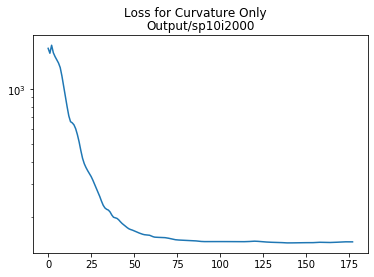

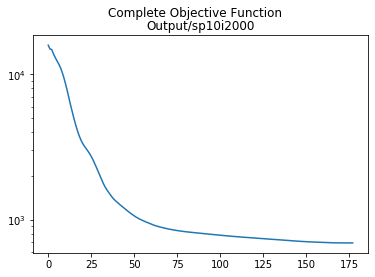

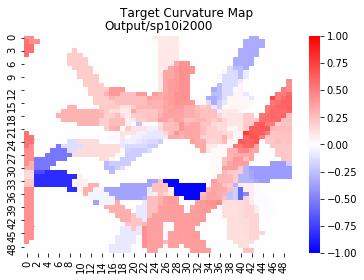

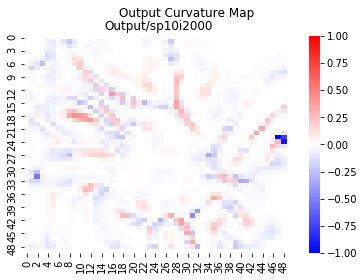

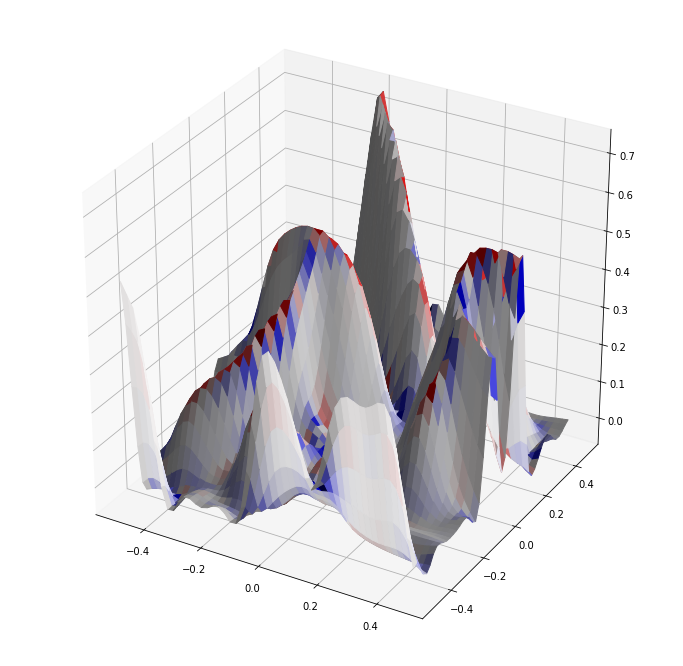

In [42]:
smooth_pen = 10
niter = 2000
momentum = 0.9
zf, cv, errvals, c_errvals = generate_surface(smooth_pen, rate, momentum, kappa, xf, yf, 
                                              t_of_v, niter = niter, verbose = True)
runname = 'Output/sp{:d}i{:d}'.format(smooth_pen, niter)
try:
    os.mkdir(runname)
except FileExistsError:
    pass
document_run(runname, zf, cv, errvals, c_errvals, kappa, gridsize)
generate_plots(runname, gridsize, xf, yf, zf, cv, 'Data/map_points.csv', refc)

starting rate setting: rate: 0.0001 obj fn: 2053.772845995889 complete obj fn: 298098.48261225934
setup: -- lowering rate to 9.09090909090909e-05
setup: -- lowering rate to 8.264462809917355e-05
setup: -- lowering rate to 7.513148009015777e-05
setup: -- lowering rate to 6.830134553650706e-05
setup: -- lowering rate to 6.20921323059155e-05
setup: -- lowering rate to 5.644739300537773e-05
setup: -- lowering rate to 5.131581182307066e-05
setup: -- lowering rate to 4.665073802097332e-05
setup: -- lowering rate to 4.240976183724847e-05
setup: -- lowering rate to 3.8554328942953155e-05
setup: -- lowering rate to 3.504938994813923e-05
finished rate setting: rate: 3.504938994813923e-05 obj fn: 4582.376587219471 complete obj fn: 255949.3358837016
step: 0 -- lowering rate to 3.1863081771035665e-05
step: 1 -- lowering rate to 2.8966437973668783e-05
step: 2 -- lowering rate to 2.633312543060798e-05
step: 3 -- lowering rate to 2.3939204936916344e-05
step: 4 -- lowering rate to 2.1762913579014857e-0

step: 821 -- lowering rate to 6.799702492444859e-11
step: 822 -- lowering rate to 6.181547720404416e-11
step: 823 -- lowering rate to 5.619588836731287e-11
step: 824 -- lowering rate to 5.1087171243011696e-11
step: 825 -- lowering rate to 4.6442882948192444e-11
step: 826 -- lowering rate to 4.222080268017495e-11
step: 827 -- lowering rate to 3.838254789106813e-11
step: 828 -- lowering rate to 3.489322535551648e-11
step: 829 -- lowering rate to 3.172111395956043e-11
step: 830 -- lowering rate to 2.8837376326873116e-11
step: 831 -- lowering rate to 2.621579666079374e-11
step: 832 -- lowering rate to 2.3832542418903398e-11
step: 833 -- lowering rate to 2.1665947653548543e-11
step: 834 -- lowering rate to 1.9696316048680493e-11
step: 835 -- lowering rate to 1.790574186243681e-11
step: 836 -- lowering rate to 1.6277947147669826e-11
step: 837 -- lowering rate to 1.479813377060893e-11
step: 838 -- lowering rate to 1.3452848882371755e-11
step: 839 -- lowering rate to 1.2229862620337958e-11
ste

step: 979 -- lowering rate to 2.1569413765395054e-17
step: 980 -- lowering rate to 1.9608557968540955e-17
step: 981 -- lowering rate to 1.7825961789582685e-17
step: 982 -- lowering rate to 1.620541980871153e-17
step: 983 -- lowering rate to 1.473219982610139e-17
step: 984 -- lowering rate to 1.3392908932819444e-17
step: 985 -- lowering rate to 1.2175371757108585e-17
step: 986 -- lowering rate to 1.1068519779189621e-17
step: 987 -- lowering rate to 1.00622907083542e-17
step: 988 -- lowering rate to 9.147537007594726e-18
step: 989 -- lowering rate to 8.315942734177023e-18
step: 990 -- lowering rate to 7.559947940160929e-18
step: 991 -- lowering rate to 6.872679945600844e-18
step: 992 -- lowering rate to 6.2478908596371304e-18
step: 993 -- lowering rate to 5.6799007814883e-18
step: 994 -- lowering rate to 5.163546164989363e-18
step: 995 -- lowering rate to 4.694132877263057e-18
step: 996 -- lowering rate to 4.267393524784597e-18
step: 997 -- lowering rate to 3.879448658895088e-18
step: 99

step: 1134 -- raising rate to 2.1898476309283657e-18
step: 1135 -- lowering rate to 1.9907705735712415e-18
step: 1136 -- raising rate to 2.1898476309283657e-18
step: 1137 -- lowering rate to 1.9907705735712415e-18
step: 1138 -- raising rate to 2.1898476309283657e-18
step: 1139 -- lowering rate to 1.9907705735712415e-18
step: 1140 -- raising rate to 2.1898476309283657e-18
step: 1141 -- lowering rate to 1.9907705735712415e-18
step: 1142 -- raising rate to 2.1898476309283657e-18
step: 1143 -- lowering rate to 1.9907705735712415e-18
step: 1144 -- raising rate to 2.1898476309283657e-18
step: 1145 -- lowering rate to 1.9907705735712415e-18
step: 1146 -- raising rate to 2.1898476309283657e-18
step: 1147 -- lowering rate to 1.9907705735712415e-18
step: 1148 -- raising rate to 2.1898476309283657e-18
step: 1149 -- lowering rate to 1.9907705735712415e-18
step: 1150 -- raising rate to 2.1898476309283657e-18
step: 1151 -- lowering rate to 1.9907705735712415e-18
step: 1152 -- raising rate to 2.18984

step: 1288 -- raising rate to 2.1898476309283657e-18
step: 1289 -- lowering rate to 1.9907705735712415e-18
step: 1290 -- raising rate to 2.1898476309283657e-18
step: 1291 -- lowering rate to 1.9907705735712415e-18
step: 1292 -- raising rate to 2.1898476309283657e-18
step: 1293 -- lowering rate to 1.9907705735712415e-18
step: 1294 -- raising rate to 2.1898476309283657e-18
step: 1295 -- lowering rate to 1.9907705735712415e-18
step: 1296 -- raising rate to 2.1898476309283657e-18
step: 1297 -- lowering rate to 1.9907705735712415e-18
step: 1298 -- raising rate to 2.1898476309283657e-18
step: 1299 -- lowering rate to 1.9907705735712415e-18
step: 1300 -- raising rate to 2.1898476309283657e-18
step: 1301 -- lowering rate to 1.9907705735712415e-18
step: 1302 -- raising rate to 2.1898476309283657e-18
step: 1303 -- lowering rate to 1.9907705735712415e-18
step: 1304 -- raising rate to 2.1898476309283657e-18
step: 1305 -- lowering rate to 1.9907705735712415e-18
step: 1306 -- raising rate to 2.18984

step: 1442 -- raising rate to 2.1898476309283657e-18
step: 1443 -- lowering rate to 1.9907705735712415e-18
step: 1444 -- raising rate to 2.1898476309283657e-18
step: 1445 -- lowering rate to 1.9907705735712415e-18
step: 1446 -- raising rate to 2.1898476309283657e-18
step: 1447 -- lowering rate to 1.9907705735712415e-18
step: 1448 -- raising rate to 2.1898476309283657e-18
step: 1449 -- lowering rate to 1.9907705735712415e-18
step: 1450 -- raising rate to 2.1898476309283657e-18
step: 1451 -- lowering rate to 1.9907705735712415e-18
step: 1452 -- raising rate to 2.1898476309283657e-18
step: 1453 -- lowering rate to 1.9907705735712415e-18
step: 1454 -- raising rate to 2.1898476309283657e-18
step: 1455 -- lowering rate to 1.9907705735712415e-18
step: 1456 -- raising rate to 2.1898476309283657e-18
step: 1457 -- lowering rate to 1.9907705735712415e-18
step: 1458 -- raising rate to 2.1898476309283657e-18
step: 1459 -- lowering rate to 1.9907705735712415e-18
step: 1460 -- raising rate to 2.18984

step: 1596 -- raising rate to 2.1898476309283657e-18
step: 1597 -- lowering rate to 1.9907705735712415e-18
step: 1598 -- raising rate to 2.1898476309283657e-18
step: 1599 -- lowering rate to 1.9907705735712415e-18
step: 1600 -- raising rate to 2.1898476309283657e-18
step: 1601 -- lowering rate to 1.9907705735712415e-18
step: 1602 -- raising rate to 2.1898476309283657e-18
step: 1603 -- lowering rate to 1.9907705735712415e-18
step: 1604 -- raising rate to 2.1898476309283657e-18
step: 1605 -- lowering rate to 1.9907705735712415e-18
step: 1606 -- raising rate to 2.1898476309283657e-18
step: 1607 -- lowering rate to 1.9907705735712415e-18
step: 1608 -- raising rate to 2.1898476309283657e-18
step: 1609 -- lowering rate to 1.9907705735712415e-18
step: 1610 -- raising rate to 2.1898476309283657e-18
step: 1611 -- lowering rate to 1.9907705735712415e-18
step: 1612 -- raising rate to 2.1898476309283657e-18
step: 1613 -- lowering rate to 1.9907705735712415e-18
step: 1614 -- raising rate to 2.18984

step: 1750 -- raising rate to 2.1898476309283657e-18
step: 1751 -- lowering rate to 1.9907705735712415e-18
step: 1752 -- raising rate to 2.1898476309283657e-18
step: 1753 -- lowering rate to 1.9907705735712415e-18
step: 1754 -- raising rate to 2.1898476309283657e-18
step: 1755 -- lowering rate to 1.9907705735712415e-18
step: 1756 -- raising rate to 2.1898476309283657e-18
step: 1757 -- lowering rate to 1.9907705735712415e-18
step: 1758 -- raising rate to 2.1898476309283657e-18
step: 1759 -- lowering rate to 1.9907705735712415e-18
step: 1760 -- raising rate to 2.1898476309283657e-18
step: 1761 -- lowering rate to 1.9907705735712415e-18
step: 1762 -- raising rate to 2.1898476309283657e-18
step: 1763 -- lowering rate to 1.9907705735712415e-18
step: 1764 -- raising rate to 2.1898476309283657e-18
step: 1765 -- lowering rate to 1.9907705735712415e-18
step: 1766 -- raising rate to 2.1898476309283657e-18
step: 1767 -- lowering rate to 1.9907705735712415e-18
step: 1768 -- raising rate to 2.18984

step: 1904 -- raising rate to 2.1898476309283657e-18
step: 1905 -- lowering rate to 1.9907705735712415e-18
step: 1906 -- raising rate to 2.1898476309283657e-18
step: 1907 -- lowering rate to 1.9907705735712415e-18
step: 1908 -- raising rate to 2.1898476309283657e-18
step: 1909 -- lowering rate to 1.9907705735712415e-18
step: 1910 -- raising rate to 2.1898476309283657e-18
step: 1911 -- lowering rate to 1.9907705735712415e-18
step: 1912 -- raising rate to 2.1898476309283657e-18
step: 1913 -- lowering rate to 1.9907705735712415e-18
step: 1914 -- raising rate to 2.1898476309283657e-18
step: 1915 -- lowering rate to 1.9907705735712415e-18
step: 1916 -- raising rate to 2.1898476309283657e-18
step: 1917 -- lowering rate to 1.9907705735712415e-18
step: 1918 -- raising rate to 2.1898476309283657e-18
step: 1919 -- lowering rate to 1.9907705735712415e-18
step: 1920 -- raising rate to 2.1898476309283657e-18
step: 1921 -- lowering rate to 1.9907705735712415e-18
step: 1922 -- raising rate to 2.18984

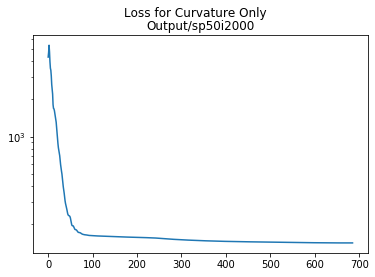

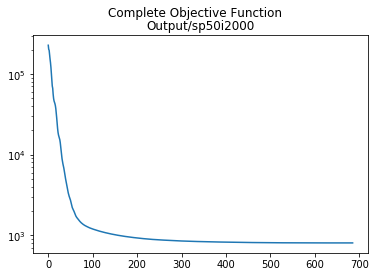

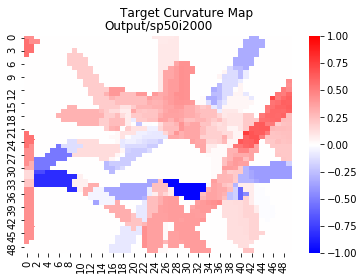

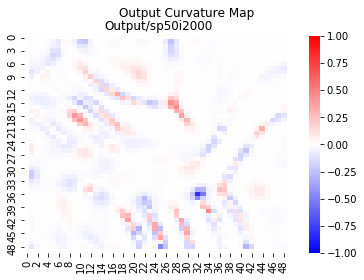

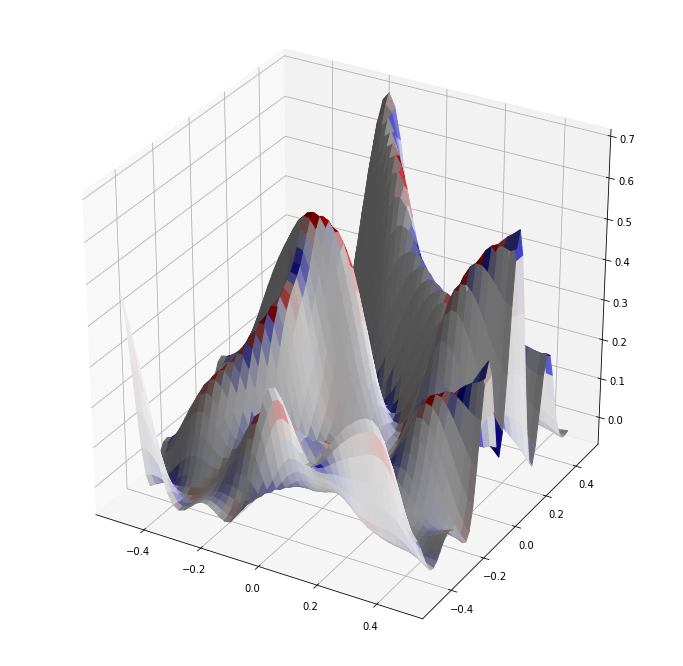

In [43]:
smooth_pen = 50
niter = 2000
momentum = 0.9
zf, cv, errvals, c_errvals = generate_surface(smooth_pen, rate, momentum, kappa, xf, yf, 
                                              t_of_v, niter = niter, verbose = True)
runname = 'Output/sp{:d}i{:d}'.format(smooth_pen, niter)
try:
    os.mkdir(runname)
except FileExistsError:
    pass
document_run(runname, zf, cv, errvals, c_errvals, kappa, gridsize)
generate_plots(runname, gridsize, xf, yf, zf, cv, 'Data/map_points.csv', refc)

starting rate setting: rate: 0.0001 obj fn: 2053.772845995889 complete obj fn: 31658.243822622233
finished rate setting: rate: 0.0001 obj fn: 2323.85653585419 complete obj fn: 12385.971270816852
step: 0 -- lowering rate to 9.09090909090909e-05
step: 2 -- lowering rate to 8.264462809917355e-05
step: 3 -- lowering rate to 7.513148009015777e-05
step: 4 -- lowering rate to 6.830134553650706e-05
step: 5 -- lowering rate to 6.20921323059155e-05
step: 7 -- lowering rate to 5.644739300537773e-05
step: 8 -- lowering rate to 5.131581182307066e-05
step: 10 -- lowering rate to 4.665073802097332e-05
step: 100, obj fn: 144.3002402117523
step: 200, obj fn: 134.26624654720717
step: 300, obj fn: 132.4931671024204
step: 400, obj fn: 131.6815285836831
step: 448 -- lowering rate to 4.240976183724847e-05
step: 449 -- lowering rate to 3.8554328942953155e-05
step: 450 -- lowering rate to 3.504938994813923e-05
step: 451 -- lowering rate to 3.1863081771035665e-05
step: 452 -- lowering rate to 2.896643797366878

step: 591 -- lowering rate to 5.1087171243011696e-11
step: 592 -- lowering rate to 4.6442882948192444e-11
step: 593 -- lowering rate to 4.222080268017495e-11
step: 594 -- lowering rate to 3.838254789106813e-11
step: 595 -- lowering rate to 3.489322535551648e-11
step: 596 -- lowering rate to 3.172111395956043e-11
step: 597 -- lowering rate to 2.8837376326873116e-11
step: 598 -- lowering rate to 2.621579666079374e-11
step: 599 -- lowering rate to 2.3832542418903398e-11
step: 600 -- lowering rate to 2.1665947653548543e-11
step: 601 -- lowering rate to 1.9696316048680493e-11
step: 602 -- lowering rate to 1.790574186243681e-11
step: 603 -- lowering rate to 1.6277947147669826e-11
step: 604 -- lowering rate to 1.479813377060893e-11
step: 605 -- lowering rate to 1.3452848882371755e-11
step: 606 -- lowering rate to 1.2229862620337958e-11
step: 607 -- lowering rate to 1.1118056927579962e-11
step: 608 -- lowering rate to 1.0107324479618146e-11
step: 609 -- lowering rate to 9.18847679965286e-12
st

step: 749 -- lowering rate to 1.620541980871153e-17
step: 750 -- lowering rate to 1.473219982610139e-17
step: 751 -- lowering rate to 1.3392908932819444e-17
step: 752 -- lowering rate to 1.2175371757108585e-17
step: 753 -- lowering rate to 1.1068519779189621e-17
step: 754 -- lowering rate to 1.00622907083542e-17
step: 755 -- lowering rate to 9.147537007594726e-18
step: 756 -- lowering rate to 8.315942734177023e-18
step: 757 -- lowering rate to 7.559947940160929e-18
step: 758 -- lowering rate to 6.872679945600844e-18
step: 759 -- lowering rate to 6.2478908596371304e-18
step: 760 -- lowering rate to 5.6799007814883e-18
step: 761 -- lowering rate to 5.163546164989363e-18
step: 762 -- lowering rate to 4.694132877263057e-18
step: 763 -- lowering rate to 4.267393524784597e-18
step: 764 -- lowering rate to 3.879448658895088e-18
step: 765 -- lowering rate to 3.526771508086443e-18
step: 766 -- lowering rate to 3.206155916442221e-18
step: 767 -- lowering rate to 2.9146871967656555e-18
step: 770 

step: 908 -- raising rate to 2.1898476309283657e-18
step: 909 -- lowering rate to 1.9907705735712415e-18
step: 910 -- raising rate to 2.1898476309283657e-18
step: 911 -- lowering rate to 1.9907705735712415e-18
step: 912 -- raising rate to 2.1898476309283657e-18
step: 913 -- lowering rate to 1.9907705735712415e-18
step: 914 -- raising rate to 2.1898476309283657e-18
step: 915 -- lowering rate to 1.9907705735712415e-18
step: 916 -- raising rate to 2.1898476309283657e-18
step: 917 -- lowering rate to 1.9907705735712415e-18
step: 918 -- raising rate to 2.1898476309283657e-18
step: 919 -- lowering rate to 1.9907705735712415e-18
step: 920 -- raising rate to 2.1898476309283657e-18
step: 921 -- lowering rate to 1.9907705735712415e-18
step: 922 -- raising rate to 2.1898476309283657e-18
step: 923 -- lowering rate to 1.9907705735712415e-18
step: 924 -- raising rate to 2.1898476309283657e-18
step: 925 -- lowering rate to 1.9907705735712415e-18
step: 926 -- raising rate to 2.1898476309283657e-18
ste

step: 1063 -- lowering rate to 1.9907705735712415e-18
step: 1064 -- raising rate to 2.1898476309283657e-18
step: 1065 -- lowering rate to 1.9907705735712415e-18
step: 1066 -- raising rate to 2.1898476309283657e-18
step: 1067 -- lowering rate to 1.9907705735712415e-18
step: 1068 -- raising rate to 2.1898476309283657e-18
step: 1069 -- lowering rate to 1.9907705735712415e-18
step: 1070 -- raising rate to 2.1898476309283657e-18
step: 1071 -- lowering rate to 1.9907705735712415e-18
step: 1072 -- raising rate to 2.1898476309283657e-18
step: 1073 -- lowering rate to 1.9907705735712415e-18
step: 1074 -- raising rate to 2.1898476309283657e-18
step: 1075 -- lowering rate to 1.9907705735712415e-18
step: 1076 -- raising rate to 2.1898476309283657e-18
step: 1077 -- lowering rate to 1.9907705735712415e-18
step: 1078 -- raising rate to 2.1898476309283657e-18
step: 1079 -- lowering rate to 1.9907705735712415e-18
step: 1080 -- raising rate to 2.1898476309283657e-18
step: 1081 -- lowering rate to 1.9907

step: 1217 -- lowering rate to 1.9907705735712415e-18
step: 1218 -- raising rate to 2.1898476309283657e-18
step: 1219 -- lowering rate to 1.9907705735712415e-18
step: 1220 -- raising rate to 2.1898476309283657e-18
step: 1221 -- lowering rate to 1.9907705735712415e-18
step: 1222 -- raising rate to 2.1898476309283657e-18
step: 1223 -- lowering rate to 1.9907705735712415e-18
step: 1224 -- raising rate to 2.1898476309283657e-18
step: 1225 -- lowering rate to 1.9907705735712415e-18
step: 1226 -- raising rate to 2.1898476309283657e-18
step: 1227 -- lowering rate to 1.9907705735712415e-18
step: 1228 -- raising rate to 2.1898476309283657e-18
step: 1229 -- lowering rate to 1.9907705735712415e-18
step: 1230 -- raising rate to 2.1898476309283657e-18
step: 1231 -- lowering rate to 1.9907705735712415e-18
step: 1232 -- raising rate to 2.1898476309283657e-18
step: 1233 -- lowering rate to 1.9907705735712415e-18
step: 1234 -- raising rate to 2.1898476309283657e-18
step: 1235 -- lowering rate to 1.9907

step: 1371 -- lowering rate to 1.9907705735712415e-18
step: 1372 -- raising rate to 2.1898476309283657e-18
step: 1373 -- lowering rate to 1.9907705735712415e-18
step: 1374 -- raising rate to 2.1898476309283657e-18
step: 1375 -- lowering rate to 1.9907705735712415e-18
step: 1376 -- raising rate to 2.1898476309283657e-18
step: 1377 -- lowering rate to 1.9907705735712415e-18
step: 1378 -- raising rate to 2.1898476309283657e-18
step: 1379 -- lowering rate to 1.9907705735712415e-18
step: 1380 -- raising rate to 2.1898476309283657e-18
step: 1381 -- lowering rate to 1.9907705735712415e-18
step: 1382 -- raising rate to 2.1898476309283657e-18
step: 1383 -- lowering rate to 1.9907705735712415e-18
step: 1384 -- raising rate to 2.1898476309283657e-18
step: 1385 -- lowering rate to 1.9907705735712415e-18
step: 1386 -- raising rate to 2.1898476309283657e-18
step: 1387 -- lowering rate to 1.9907705735712415e-18
step: 1388 -- raising rate to 2.1898476309283657e-18
step: 1389 -- lowering rate to 1.9907

step: 1525 -- lowering rate to 1.9907705735712415e-18
step: 1526 -- raising rate to 2.1898476309283657e-18
step: 1527 -- lowering rate to 1.9907705735712415e-18
step: 1528 -- raising rate to 2.1898476309283657e-18
step: 1529 -- lowering rate to 1.9907705735712415e-18
step: 1530 -- raising rate to 2.1898476309283657e-18
step: 1531 -- lowering rate to 1.9907705735712415e-18
step: 1532 -- raising rate to 2.1898476309283657e-18
step: 1533 -- lowering rate to 1.9907705735712415e-18
step: 1534 -- raising rate to 2.1898476309283657e-18
step: 1535 -- lowering rate to 1.9907705735712415e-18
step: 1536 -- raising rate to 2.1898476309283657e-18
step: 1537 -- lowering rate to 1.9907705735712415e-18
step: 1538 -- raising rate to 2.1898476309283657e-18
step: 1539 -- lowering rate to 1.9907705735712415e-18
step: 1540 -- raising rate to 2.1898476309283657e-18
step: 1541 -- lowering rate to 1.9907705735712415e-18
step: 1542 -- raising rate to 2.1898476309283657e-18
step: 1543 -- lowering rate to 1.9907

step: 1679 -- lowering rate to 1.9907705735712415e-18
step: 1680 -- raising rate to 2.1898476309283657e-18
step: 1681 -- lowering rate to 1.9907705735712415e-18
step: 1682 -- raising rate to 2.1898476309283657e-18
step: 1683 -- lowering rate to 1.9907705735712415e-18
step: 1684 -- raising rate to 2.1898476309283657e-18
step: 1685 -- lowering rate to 1.9907705735712415e-18
step: 1686 -- raising rate to 2.1898476309283657e-18
step: 1687 -- lowering rate to 1.9907705735712415e-18
step: 1688 -- raising rate to 2.1898476309283657e-18
step: 1689 -- lowering rate to 1.9907705735712415e-18
step: 1690 -- raising rate to 2.1898476309283657e-18
step: 1691 -- lowering rate to 1.9907705735712415e-18
step: 1692 -- raising rate to 2.1898476309283657e-18
step: 1693 -- lowering rate to 1.9907705735712415e-18
step: 1694 -- raising rate to 2.1898476309283657e-18
step: 1695 -- lowering rate to 1.9907705735712415e-18
step: 1696 -- raising rate to 2.1898476309283657e-18
step: 1697 -- lowering rate to 1.9907

step: 1833 -- lowering rate to 1.9907705735712415e-18
step: 1834 -- raising rate to 2.1898476309283657e-18
step: 1835 -- lowering rate to 1.9907705735712415e-18
step: 1836 -- raising rate to 2.1898476309283657e-18
step: 1837 -- lowering rate to 1.9907705735712415e-18
step: 1838 -- raising rate to 2.1898476309283657e-18
step: 1839 -- lowering rate to 1.9907705735712415e-18
step: 1840 -- raising rate to 2.1898476309283657e-18
step: 1841 -- lowering rate to 1.9907705735712415e-18
step: 1842 -- raising rate to 2.1898476309283657e-18
step: 1843 -- lowering rate to 1.9907705735712415e-18
step: 1844 -- raising rate to 2.1898476309283657e-18
step: 1845 -- lowering rate to 1.9907705735712415e-18
step: 1846 -- raising rate to 2.1898476309283657e-18
step: 1847 -- lowering rate to 1.9907705735712415e-18
step: 1848 -- raising rate to 2.1898476309283657e-18
step: 1849 -- lowering rate to 1.9907705735712415e-18
step: 1850 -- raising rate to 2.1898476309283657e-18
step: 1851 -- lowering rate to 1.9907

step: 1987 -- lowering rate to 1.9907705735712415e-18
step: 1988 -- raising rate to 2.1898476309283657e-18
step: 1989 -- lowering rate to 1.9907705735712415e-18
step: 1990 -- raising rate to 2.1898476309283657e-18
step: 1991 -- lowering rate to 1.9907705735712415e-18
step: 1992 -- raising rate to 2.1898476309283657e-18
step: 1993 -- lowering rate to 1.9907705735712415e-18
step: 1994 -- raising rate to 2.1898476309283657e-18
step: 1995 -- lowering rate to 1.9907705735712415e-18
step: 1996 -- raising rate to 2.1898476309283657e-18
step: 1997 -- lowering rate to 1.9907705735712415e-18
step: 1998 -- raising rate to 2.1898476309283657e-18
step: 1999 -- lowering rate to 1.9907705735712415e-18
Done: final error: 131.52772976602785


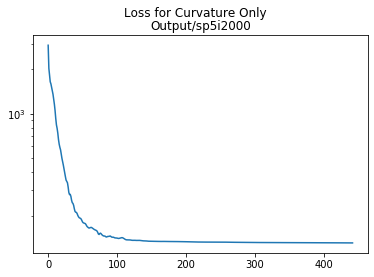

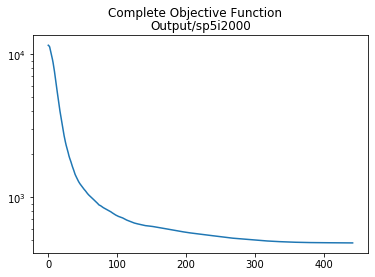

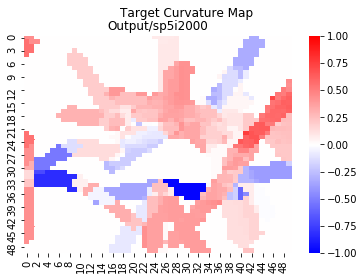

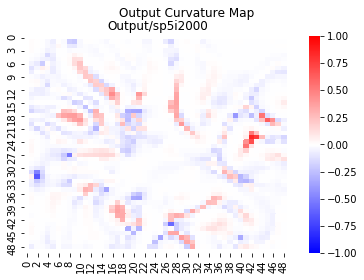

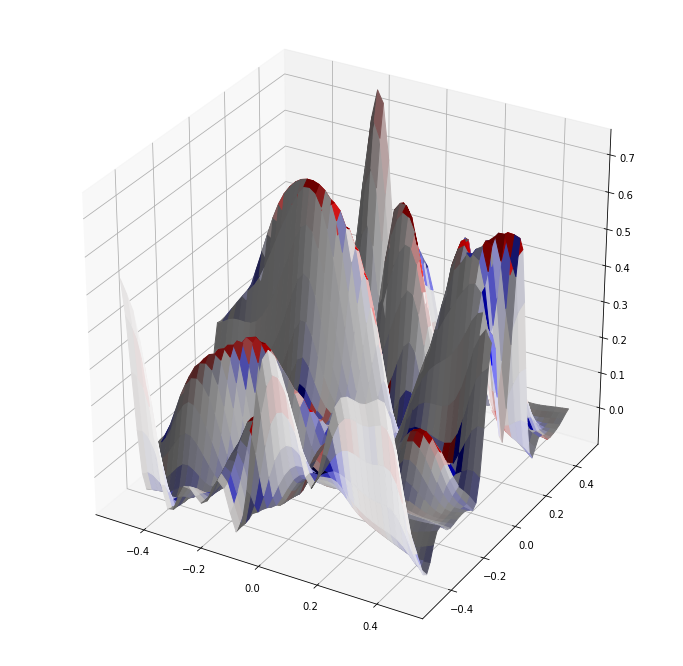

In [44]:
smooth_pen = 5
niter = 2000
momentum = 0.9
zf, cv, errvals, c_errvals = generate_surface(smooth_pen, rate, momentum, kappa, xf, yf, 
                                              t_of_v, niter = niter, verbose = True)
runname = 'Output/sp{:d}i{:d}'.format(smooth_pen, niter)
try:
    os.mkdir(runname)
except FileExistsError:
    pass
document_run(runname, zf, cv, errvals, c_errvals, kappa, gridsize)
generate_plots(runname, gridsize, xf, yf, zf, cv, 'Data/map_points.csv', refc)

starting rate setting: rate: 0.0001 obj fn: 2053.772845995889 complete obj fn: 298098.48261225934
setup: -- lowering rate to 9.09090909090909e-05
setup: -- lowering rate to 8.264462809917355e-05
setup: -- lowering rate to 7.513148009015777e-05
setup: -- lowering rate to 6.830134553650706e-05
setup: -- lowering rate to 6.20921323059155e-05
setup: -- lowering rate to 5.644739300537773e-05
setup: -- lowering rate to 5.131581182307066e-05
setup: -- lowering rate to 4.665073802097332e-05
setup: -- lowering rate to 4.240976183724847e-05
setup: -- lowering rate to 3.8554328942953155e-05
setup: -- lowering rate to 3.504938994813923e-05
finished rate setting: rate: 3.504938994813923e-05 obj fn: 4582.376587219471 complete obj fn: 255949.3358837016
step: 0 -- lowering rate to 3.1863081771035665e-05
step: 1 -- lowering rate to 2.8966437973668783e-05
step: 2 -- lowering rate to 2.633312543060798e-05
step: 3 -- lowering rate to 2.3939204936916344e-05
step: 4 -- lowering rate to 2.1762913579014857e-0

step: 821 -- lowering rate to 6.799702492444859e-11
step: 822 -- lowering rate to 6.181547720404416e-11
step: 823 -- lowering rate to 5.619588836731287e-11
step: 824 -- lowering rate to 5.1087171243011696e-11
step: 825 -- lowering rate to 4.6442882948192444e-11
step: 826 -- lowering rate to 4.222080268017495e-11
step: 827 -- lowering rate to 3.838254789106813e-11
step: 828 -- lowering rate to 3.489322535551648e-11
step: 829 -- lowering rate to 3.172111395956043e-11
step: 830 -- lowering rate to 2.8837376326873116e-11
step: 831 -- lowering rate to 2.621579666079374e-11
step: 832 -- lowering rate to 2.3832542418903398e-11
step: 833 -- lowering rate to 2.1665947653548543e-11
step: 834 -- lowering rate to 1.9696316048680493e-11
step: 835 -- lowering rate to 1.790574186243681e-11
step: 836 -- lowering rate to 1.6277947147669826e-11
step: 837 -- lowering rate to 1.479813377060893e-11
step: 838 -- lowering rate to 1.3452848882371755e-11
step: 839 -- lowering rate to 1.2229862620337958e-11
ste

step: 979 -- lowering rate to 2.1569413765395054e-17
step: 980 -- lowering rate to 1.9608557968540955e-17
step: 981 -- lowering rate to 1.7825961789582685e-17
step: 982 -- lowering rate to 1.620541980871153e-17
step: 983 -- lowering rate to 1.473219982610139e-17
step: 984 -- lowering rate to 1.3392908932819444e-17
step: 985 -- lowering rate to 1.2175371757108585e-17
step: 986 -- lowering rate to 1.1068519779189621e-17
step: 987 -- lowering rate to 1.00622907083542e-17
step: 988 -- lowering rate to 9.147537007594726e-18
step: 989 -- lowering rate to 8.315942734177023e-18
step: 990 -- lowering rate to 7.559947940160929e-18
step: 991 -- lowering rate to 6.872679945600844e-18
step: 992 -- lowering rate to 6.2478908596371304e-18
step: 993 -- lowering rate to 5.6799007814883e-18
step: 994 -- lowering rate to 5.163546164989363e-18
step: 995 -- lowering rate to 4.694132877263057e-18
step: 996 -- lowering rate to 4.267393524784597e-18
step: 997 -- lowering rate to 3.879448658895088e-18
step: 99

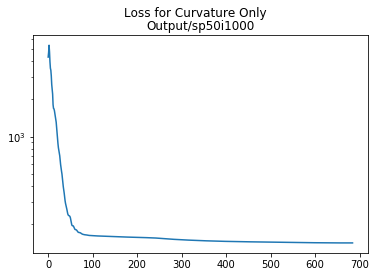

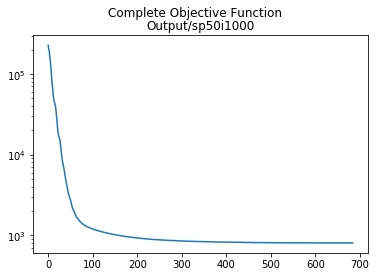

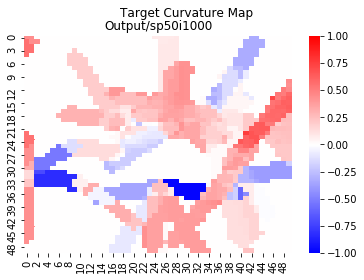

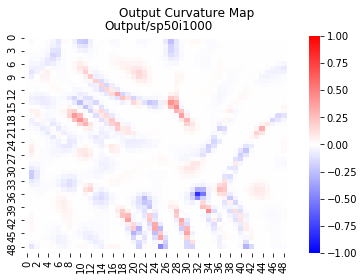

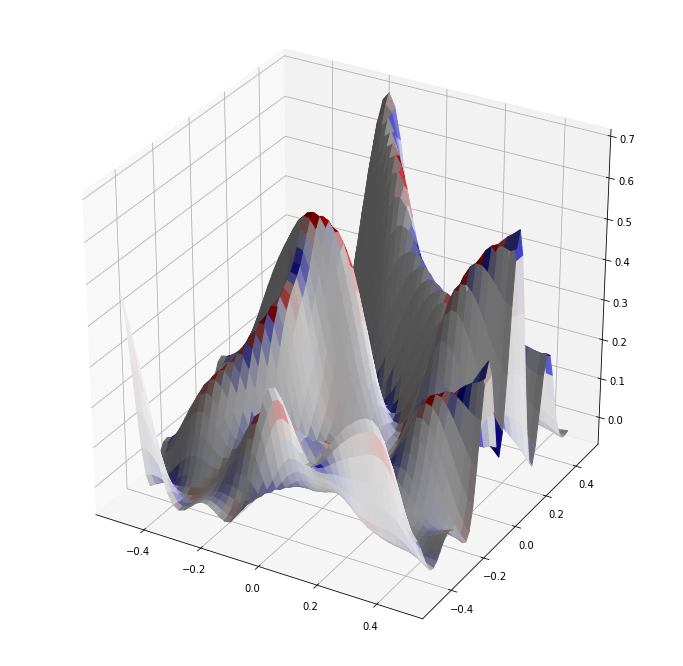

In [45]:
smooth_pen = 50
niter = 1000
momentum = 0.9
zf, cv, errvals, c_errvals = generate_surface(smooth_pen, rate, momentum, kappa, xf, yf, 
                                              t_of_v, niter = niter, verbose = True)
runname = 'Output/sp{:d}i{:d}'.format(smooth_pen, niter)
try:
    os.mkdir(runname)
except FileExistsError:
    pass
document_run(runname, zf, cv, errvals, c_errvals, kappa, gridsize)
generate_plots(runname, gridsize, xf, yf, zf, cv, 'Data/map_points.csv', refc)

starting rate setting: rate: 0.0001 obj fn: 2053.772845995889 complete obj fn: 31658.243822622233
finished rate setting: rate: 0.0001 obj fn: 2323.85653585419 complete obj fn: 12385.971270816852
step: 0 -- lowering rate to 9.09090909090909e-05
step: 2 -- lowering rate to 8.264462809917355e-05
step: 3 -- lowering rate to 7.513148009015777e-05
step: 4 -- lowering rate to 6.830134553650706e-05
step: 5 -- lowering rate to 6.20921323059155e-05
step: 7 -- lowering rate to 5.644739300537773e-05
step: 8 -- lowering rate to 5.131581182307066e-05
step: 10 -- lowering rate to 4.665073802097332e-05
step: 100, obj fn: 144.3002402117523
step: 200, obj fn: 134.26624654720717
step: 300, obj fn: 132.4931671024204
step: 400, obj fn: 131.6815285836831
step: 448 -- lowering rate to 4.240976183724847e-05
step: 449 -- lowering rate to 3.8554328942953155e-05
step: 450 -- lowering rate to 3.504938994813923e-05
step: 451 -- lowering rate to 3.1863081771035665e-05
step: 452 -- lowering rate to 2.896643797366878

step: 591 -- lowering rate to 5.1087171243011696e-11
step: 592 -- lowering rate to 4.6442882948192444e-11
step: 593 -- lowering rate to 4.222080268017495e-11
step: 594 -- lowering rate to 3.838254789106813e-11
step: 595 -- lowering rate to 3.489322535551648e-11
step: 596 -- lowering rate to 3.172111395956043e-11
step: 597 -- lowering rate to 2.8837376326873116e-11
step: 598 -- lowering rate to 2.621579666079374e-11
step: 599 -- lowering rate to 2.3832542418903398e-11
step: 600 -- lowering rate to 2.1665947653548543e-11
step: 601 -- lowering rate to 1.9696316048680493e-11
step: 602 -- lowering rate to 1.790574186243681e-11
step: 603 -- lowering rate to 1.6277947147669826e-11
step: 604 -- lowering rate to 1.479813377060893e-11
step: 605 -- lowering rate to 1.3452848882371755e-11
step: 606 -- lowering rate to 1.2229862620337958e-11
step: 607 -- lowering rate to 1.1118056927579962e-11
step: 608 -- lowering rate to 1.0107324479618146e-11
step: 609 -- lowering rate to 9.18847679965286e-12
st

step: 749 -- lowering rate to 1.620541980871153e-17
step: 750 -- lowering rate to 1.473219982610139e-17
step: 751 -- lowering rate to 1.3392908932819444e-17
step: 752 -- lowering rate to 1.2175371757108585e-17
step: 753 -- lowering rate to 1.1068519779189621e-17
step: 754 -- lowering rate to 1.00622907083542e-17
step: 755 -- lowering rate to 9.147537007594726e-18
step: 756 -- lowering rate to 8.315942734177023e-18
step: 757 -- lowering rate to 7.559947940160929e-18
step: 758 -- lowering rate to 6.872679945600844e-18
step: 759 -- lowering rate to 6.2478908596371304e-18
step: 760 -- lowering rate to 5.6799007814883e-18
step: 761 -- lowering rate to 5.163546164989363e-18
step: 762 -- lowering rate to 4.694132877263057e-18
step: 763 -- lowering rate to 4.267393524784597e-18
step: 764 -- lowering rate to 3.879448658895088e-18
step: 765 -- lowering rate to 3.526771508086443e-18
step: 766 -- lowering rate to 3.206155916442221e-18
step: 767 -- lowering rate to 2.9146871967656555e-18
step: 770 

step: 908 -- raising rate to 2.1898476309283657e-18
step: 909 -- lowering rate to 1.9907705735712415e-18
step: 910 -- raising rate to 2.1898476309283657e-18
step: 911 -- lowering rate to 1.9907705735712415e-18
step: 912 -- raising rate to 2.1898476309283657e-18
step: 913 -- lowering rate to 1.9907705735712415e-18
step: 914 -- raising rate to 2.1898476309283657e-18
step: 915 -- lowering rate to 1.9907705735712415e-18
step: 916 -- raising rate to 2.1898476309283657e-18
step: 917 -- lowering rate to 1.9907705735712415e-18
step: 918 -- raising rate to 2.1898476309283657e-18
step: 919 -- lowering rate to 1.9907705735712415e-18
step: 920 -- raising rate to 2.1898476309283657e-18
step: 921 -- lowering rate to 1.9907705735712415e-18
step: 922 -- raising rate to 2.1898476309283657e-18
step: 923 -- lowering rate to 1.9907705735712415e-18
step: 924 -- raising rate to 2.1898476309283657e-18
step: 925 -- lowering rate to 1.9907705735712415e-18
step: 926 -- raising rate to 2.1898476309283657e-18
ste

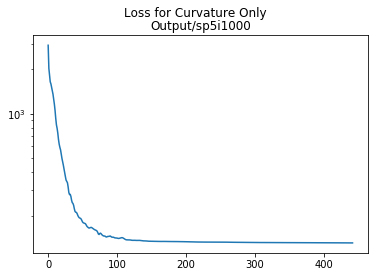

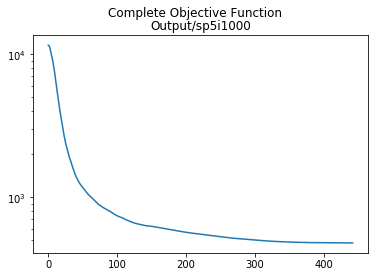

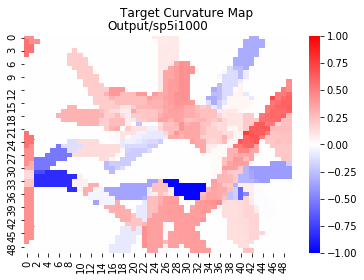

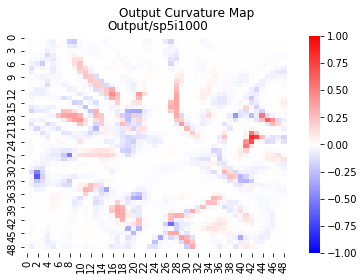

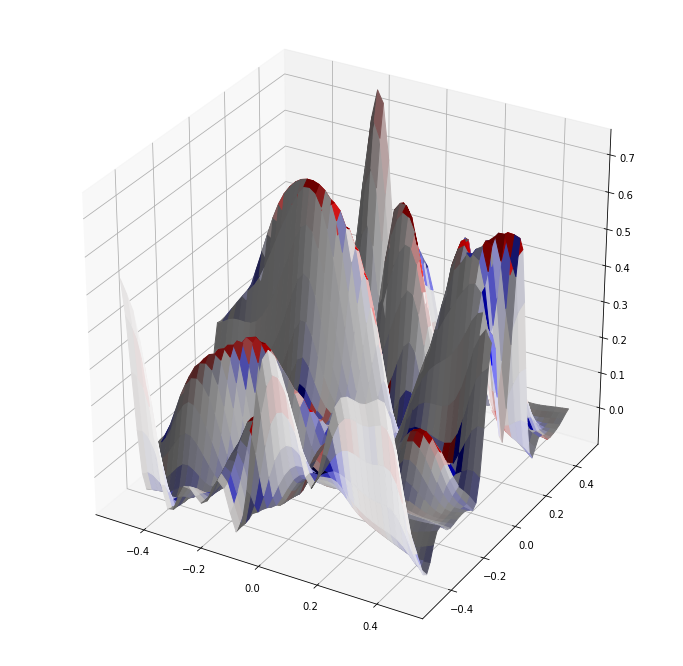

In [46]:
smooth_pen = 5
niter = 1000
momentum = 0.9
zf, cv, errvals, c_errvals = generate_surface(smooth_pen, rate, momentum, kappa, xf, yf, 
                                              t_of_v, niter = niter, verbose = True)
runname = 'Output/sp{:d}i{:d}'.format(smooth_pen, niter)
try:
    os.mkdir(runname)
except FileExistsError:
    pass
document_run(runname, zf, cv, errvals, c_errvals, kappa, gridsize)
generate_plots(runname, gridsize, xf, yf, zf, cv, 'Data/map_points.csv', refc)

starting rate setting: rate: 0.0001 obj fn: 2053.772845995889 complete obj fn: 594143.1923785227
setup: -- lowering rate to 9.09090909090909e-05
setup: -- lowering rate to 8.264462809917355e-05
setup: -- lowering rate to 7.513148009015777e-05
setup: -- lowering rate to 6.830134553650706e-05
setup: -- lowering rate to 6.20921323059155e-05
setup: -- lowering rate to 5.644739300537773e-05
setup: -- lowering rate to 5.131581182307066e-05
setup: -- lowering rate to 4.665073802097332e-05
setup: -- lowering rate to 4.240976183724847e-05
setup: -- lowering rate to 3.8554328942953155e-05
setup: -- lowering rate to 3.504938994813923e-05
setup: -- lowering rate to 3.1863081771035665e-05
setup: -- lowering rate to 2.8966437973668783e-05
setup: -- lowering rate to 2.633312543060798e-05
setup: -- lowering rate to 2.3939204936916344e-05
setup: -- lowering rate to 2.1762913579014857e-05
setup: -- lowering rate to 1.9784466890013503e-05
setup: -- lowering rate to 1.7985878990921365e-05
finished rate se

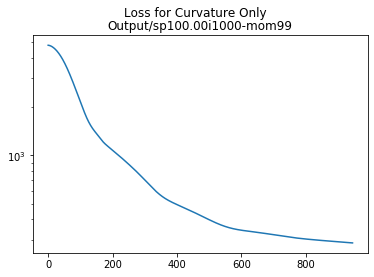

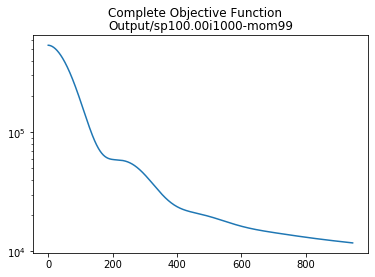

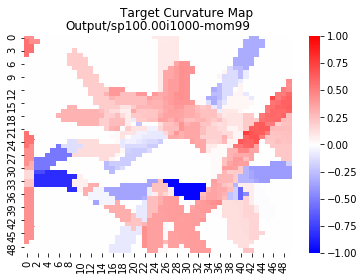

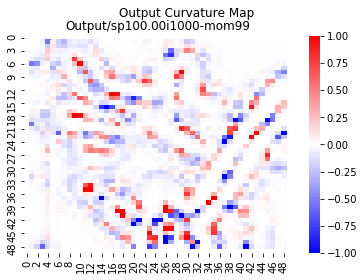

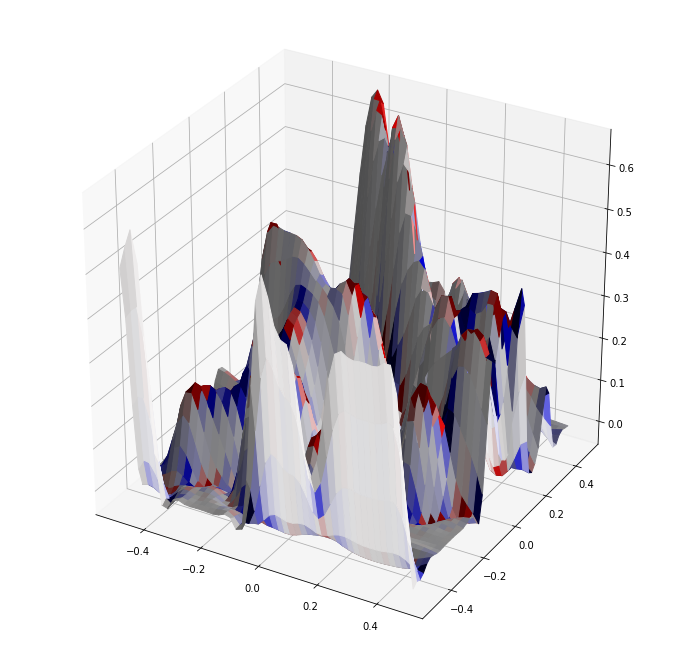

In [41]:
smooth_pen = 100
niter = 1000
momentum = 0.99
zf, cv, errvals, c_errvals = generate_surface(smooth_pen, rate, momentum, kappa, xf, yf, 
                                              t_of_v, niter = niter, verbose = True)
runname = 'Output/sp{:.2f}i{:d}-mom99'.format(smooth_pen, niter)
try:
    os.mkdir(runname)
except FileExistsError:
    pass
document_run(runname, zf, cv, errvals, c_errvals, kappa, gridsize)
generate_plots(runname, gridsize, xf, yf, zf, cv, 'Data/map_points.csv', refc)

In [36]:
# plotting options:
# plot_surface: https://matplotlib.org/gallery/mplot3d/custom_shaded_3d_surface.html#sphx-glr-gallery-mplot3d-custom-shaded-3d-surface-py
# plot_trisurf
# Poly3DCollection directly

In [37]:
triangulation = mp.tri.Triangulation(xf, yf, triangles=triangles)

NameError: name 'pcv' is not defined

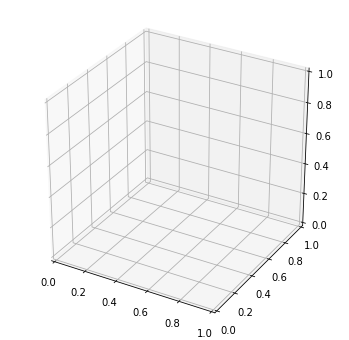

In [38]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

#ax.axes.set_xlim([xmin, xmax])
#ax.axes.set_ylim([ymin, ymax])
#ax.axes.set_zlim([zmin, zmax])
#ax.axes.set_xlabel('$x_1$',size=15)
#ax.axes.set_ylabel('$x_2$',size=15)
#ax.axes.set_zlabel('$x_3$',size=15)

#triang = mp.tri.Triangulation(X, Y, triangles=triangles)

#zs = np.array([fun(x, y) for x, y in zip(X, Y)])
facecolors = cmap([rmap(p, -maxscale, 0, maxscale, 1, 0.5) for p in pcv])
ax.plot_trisurf(triangulation,
                            zf,
                            # color='red',
                            # alpha=alpha,
                            linewidth=0, facecolors = facecolors)
plt.show()